part2 
2023.05.11 数据治理 mRNA 分类模型构建 参考Nature cfRNA文章和代码 https://github.com/miramou/pe_cfrna/tree/master/analysis

# 环境加载

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
import eli5 
from eli5.sklearn import PermutationImportance

In [2]:
import shap 
from pdpbox import pdp, info_plots 
np.random.seed(2022) 

pd.options.mode.chained_assignment = None  
%matplotlib inline

In [3]:
#查看当下路径
import os
print(os.getcwd())
os.chdir("/share/home/linmiao/bio/2022_heartEC_scRNA/mRNA/230508_3Data")
print(os.getcwd())

/share/home/linmiao/bio/2022_heartEC_scRNA/mRNA/230508_3Data
/share/home/linmiao/bio/2022_heartEC_scRNA/mRNA/230508_3Data


In [4]:
from util.gen_utils import *
from util.qc_util import *
from util.qpcr_utils import *

import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

# Exploratory Data Analysis

In [4]:
# 导入数据
dc = pd.read_csv('./discovery/discovery.csv', index_col=0)
# 输出首尾五行
dc.head()
#查看数据集一些信息 
dc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 653513_mRNA to R59_mRNA
Columns: 176 entries, VEGFA to group
dtypes: float64(175), int64(1)
memory usage: 200.5+ KB


In [5]:
#查看每列数据的数据类型
print(dc.dtypes)
#查看指定列的数据类型 
#单列
print(dc["VEGFA"].dtypes)
# 检查每个值是否为空值
null_values = dc.isnull()
# 统计每列中的空值数量
null_counts = dc.isnull().sum()
print("每列中的空值数量：\n", null_counts)

VEGFA      float64
FN1        float64
EGF        float64
KDR        float64
PECAM1     float64
            ...   
RTN4       float64
SLC12A6    float64
THSD7A     float64
ZNF304     float64
group        int64
Length: 176, dtype: object
float64
每列中的空值数量：
 VEGFA      0
FN1        0
EGF        0
KDR        0
PECAM1     0
          ..
RTN4       0
SLC12A6    0
THSD7A     0
ZNF304     0
group      0
Length: 176, dtype: int64


In [16]:
# 2.1.1 返回频数、均值、标准差、四分位数
print(dc.describe(include="all"))
#dt.describe(include=[object])
#help(pd.DataFrame.describe)

## 2.1.2计算数据的偏度 
#偏度值为0，则表示数据分布对称。如果偏度值为正数，则表示数据分布向左倾斜，如果偏度值为负数，则表示数据分布向右倾斜
print(dc.skew())

            VEGFA         FN1         EGF         KDR       PECAM1       FGF2  \
count  145.000000  145.000000  145.000000  145.000000   145.000000  145.00000   
mean   240.020413   71.062982   93.152002   90.386446   512.910228   98.42206   
std     84.182685   10.860154   17.241283   14.628975   241.402475   21.06265   
min    116.690500   54.532500   53.731920   57.320000   206.863300   63.78668   
25%    180.372300   64.683460   81.179460   81.011640   358.243700   83.82417   
50%    231.084700   69.168510   91.346370   88.115160   468.057300   94.13039   
75%    277.445800   74.323870  102.118400   97.814930   613.767400  108.89830   
max    783.431000  151.390200  156.790800  152.136500  2067.621000  178.79370   

             ITGB1       NOTCH1       HIF1A          TEK  ...       OVOL2  \
count   145.000000   145.000000  145.000000   145.000000  ...  145.000000   
mean   2303.820332   492.755137  170.784599   521.100202  ...   65.735339   
std     796.145244   170.833267   66.19

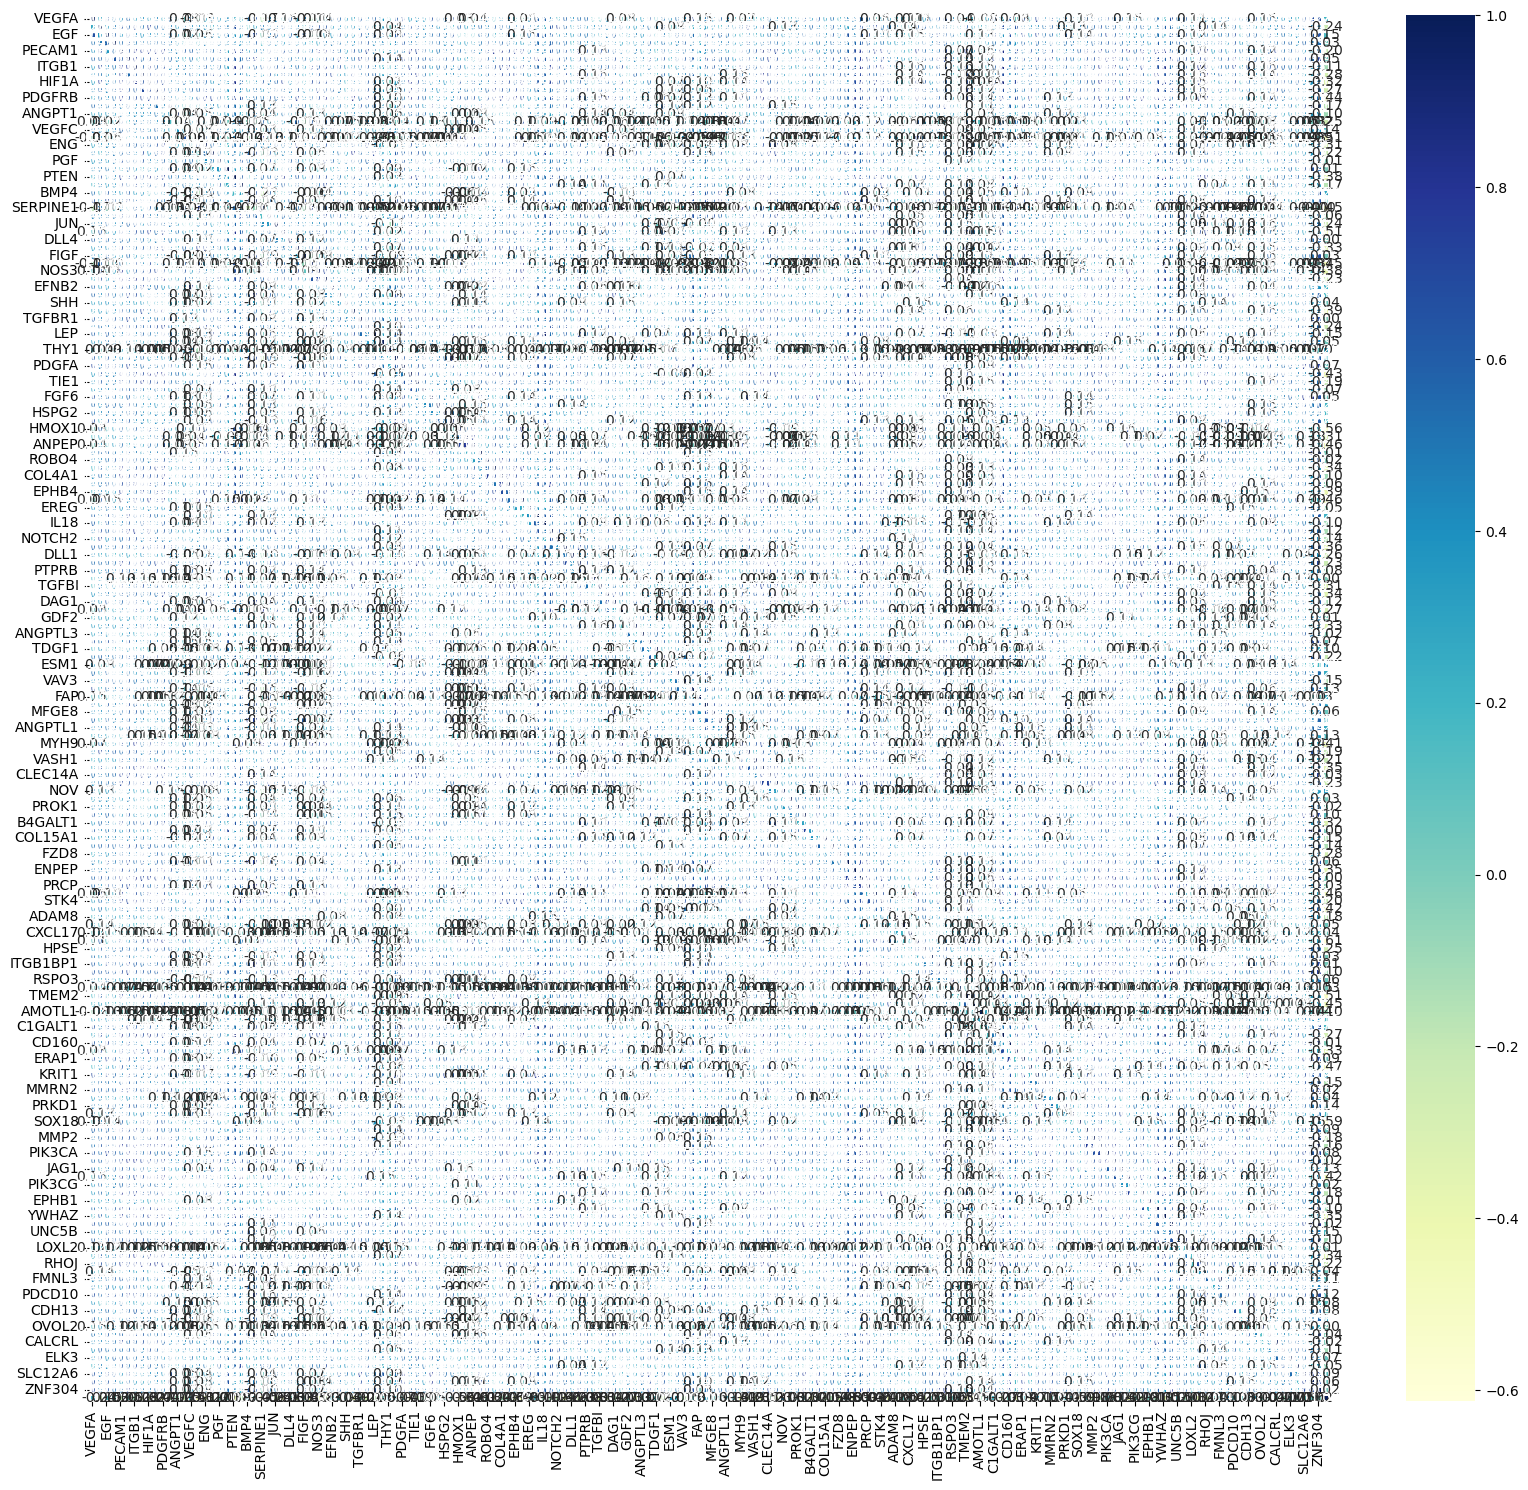

In [6]:
# 3.1 变量间相关性
plt.figure(figsize=(20,18))
#采用sns.heatmap()是Seaborn库中的一个函数，用于绘制热力图
sns.heatmap(dc.corr(),annot=True,cmap='YlGnBu',fmt='.2f',linewidths=2)
plt.savefig('./discovery/0511_heatmapplot.pdf')

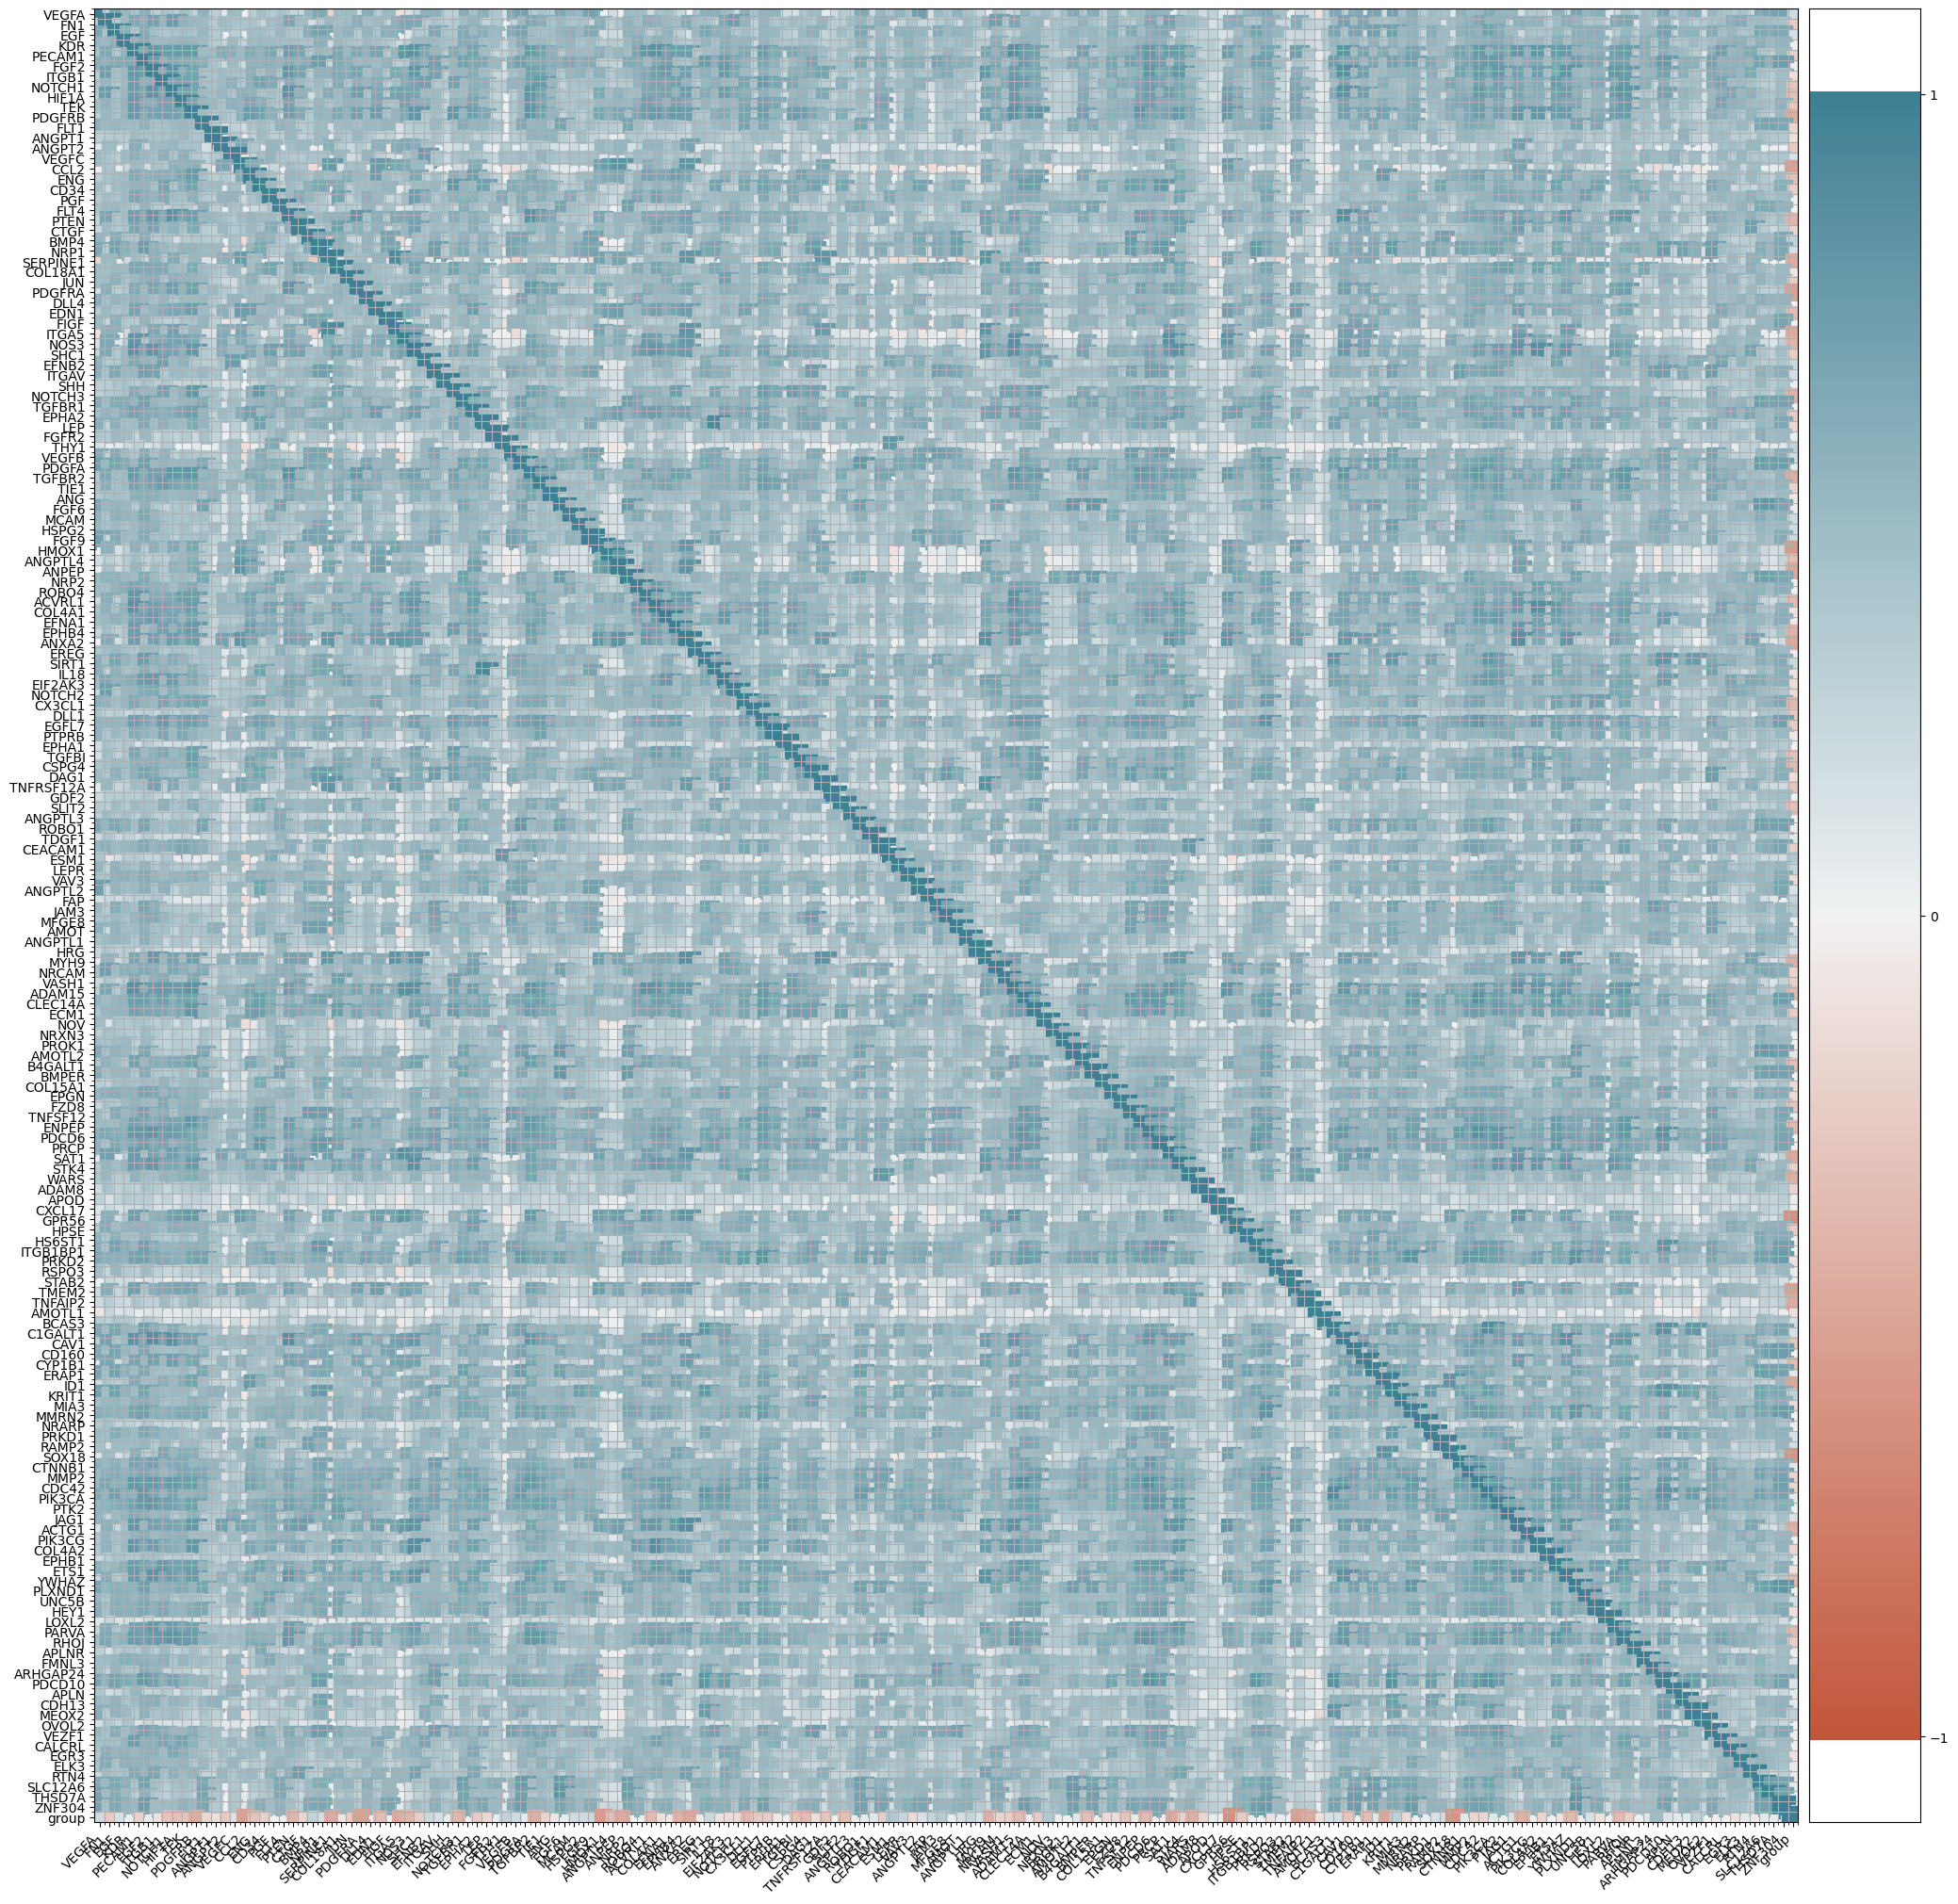

In [7]:
# 3.1 变量间相关性
from heatmap import heatmap, corrplot
plt.figure(figsize=(25, 25))
corrplot(dc.corr(), size_scale=300)
plt.savefig('./discovery/0511_corrplot.pdf')

# Train mask

In [8]:
# 对除了group的参数
X = np.log(dc.drop('group', axis=1))
X.tail()
# 合并参数和group列
dc = pd.concat([dc['group'], X], axis=1)
dc

group     VEGFA       FN1       EGF       KDR    PECAM1  \
653513_mRNA       1  5.372129  4.278086  4.375709  4.400282  5.984605   
647527_mRNA       1  5.453585  4.108202  4.377592  4.394593  5.636351   
634021_mRNA       1  5.196607  4.153363  4.329419  4.314178  5.596634   
43_mRNA           1  5.291397  4.167437  4.268536  4.427573  5.662488   
5059_mRNA         0  5.297975  4.243023  4.285574  4.357748  6.518581   
...             ...       ...       ...       ...       ...       ...   
5033_mRNA         0  4.918880  4.158064  4.297300  4.511086  5.901560   
R58_mRNA          1  5.374658  4.232914  4.491261  4.441775  5.622616   
673482_mRNA       1  5.375684  4.197319  4.459288  4.341664  5.332058   
R656518_mRNA      1  5.502741  4.139528  4.426653  4.492404  5.343901   
R59_mRNA          1  5.273892  4.309254  4.710423  4.466887  5.946443   

                  FGF2     ITGB1    NOTCH1     HIF1A  ...     MEOX2     OVOL2  \
653513_mRNA   4.472280  7.584676  5.843630  5.109515  ...  4.587130  4.217950   
647527_mRNA   4.339838  7.473296  5.679012  4.863385  ...  4.445295  4.369125   
634021_mRNA   4.232932  7.112564  5.746424  4.627057  ...  4.389262  4.364509   
43_mRNA       4.419253  7.365347  5.775880  4.794070  ...  4.331859  4.133593   
5059_mRNA     4.345263  7.447540  5.918196  5.153263  ...  4.561574  4.258145   
...                ...       ...       ...       ...  ...       ...       ...   
5033_mRNA     4.354792  7.719025  6.059074  5.406631  ...  4.492888  4.147054   
R58_mRNA      4.379706  7.326970  5.897665  5.013538  ...  5.178279  4.046518   
673482_mRNA   4.492944  7.445018  6.062509  5.050752  ...  4.970473  4.226073   
R656518_mRNA  4.551798  7.346899  5.912599  5.139892  ...  5.202821  4.241657   
R59_mRNA      4.428721  7.431843  6.181682  5.125138  ...  5.378715  4.243715   

                 VEZF1    CALCRL      EGR3      ELK3      RTN4   SLC12A6  \
653513_mRNA   7.339547  5.014317  4.449041  4.275422  6.231183  4.316836   
647527_mRNA   7.407155  4.776416  4.583405  4.270618  6.442996  4.270602   
634021_mRNA   7.277659  4.591444  4.440929  4.171565  5.264742  4.152555   
43_mRNA       7.267708  4.793425  4.351965  4.290643  6.051023  4.195119   
5059_mRNA     7.314601  5.253240  4.279858  4.314378  6.866998  4.178448   
...                ...       ...       ...       ...       ...       ...   
5033_mRNA     7.199341  4.977571  4.489824  4.174898  6.749922  4.147782   
R58_mRNA      7.356472  4.866005  4.548512  4.407784  6.351806  4.294382   
673482_mRNA   7.247816  4.777798  4.592095  4.325097  6.226570  4.093799   
R656518_mRNA  7.137342  4.736557  4.568865  4.273847  5.835014  4.293267   
R59_mRNA      7.601665  5.004712  4.539485  4.317184  6.665346  4.280235   

                THSD7A    ZNF304  
653513_mRNA   4.199476  4.307824  
647527_mRNA   3.991273  4.356747  
634021_mRNA   3.891664  4.229743  
43_mRNA       4.121974  4.192168  
5059_mRNA     3.997474  4.252983  
...                ...       ...  
5033_mRNA     4.187424  3.985960  
R58_mRNA      4.054185  4.155721  
673482_mRNA   4.122417  4.146070  
R656518_mRNA  4.206391  4.440627  
R59_mRNA      4.246085  4.233753  

[145 rows x 176 columns]

In [8]:
# 从dc中提取变量特征和目标变量
X = dc.drop('group', axis=1)
Y = dc['group']

# 将数据切分成训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1234,shuffle=True, stratify=None)

In [9]:
#依次展示数据变量情况
print(X_train.tail())
# print(X_test.tail())
# print(Y_train.tail())
# print(Y_test.tail())

                 VEGFA       FN1        EGF        KDR     PECAM1       FGF2  \
36_mRNA       154.4994  60.46799   85.70838   78.51451   417.2769   96.69460   
RNM05_mRNA    414.7762  79.11108  114.45020  112.12940  1272.6600  115.14460   
RNM07_mRNA    173.9090  66.52481   96.45296  114.89110   362.5351   91.68797   
R1_mRNA       218.1585  56.68096   93.86417   88.11516   376.0800   83.79488   
R620009_mRNA  179.5773  64.41148  106.92130   76.07991   324.9576   77.67287   

                 ITGB1     NOTCH1     HIF1A       TEK  ...      MEOX2  \
36_mRNA       2018.581   310.0016  124.0124  445.8746  ...   89.91685   
RNM05_mRNA    2809.339  1104.4470  269.8380  886.4461  ...  250.35760   
RNM07_mRNA    1658.327   303.3381  134.7698  424.4000  ...  127.02630   
R1_mRNA       1721.114   297.0865  125.5065  349.5610  ...  108.58900   
R620009_mRNA  1560.291   386.5802  104.9865  376.4522  ...  103.35780   

                 OVOL2     VEZF1    CALCRL       EGR3      ELK3       RTN4  \
36

## Feature selection and model training
Start with features identified in DE and identify logFC changes between healthy and HCM groups
Filter initial list based on:
Coefficient of variation cutoff [Want genes that appear to have stable logFC]
logFC cutoff [Want genes that appear to be sig different between PE and control]
To choose appro cutoff for each filter, do param sweep + LR model
Post model selection, choose appro threshold using training data

In [10]:
# 分别训练 逻辑回归（Logistic Regression）、决策树（Decision Tree）、随机森林（Random Forest）、XGBoost、LightGBM 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# 逻辑回归
lr_model = LogisticRegression(C=1.0)
lr_model.fit(X_train, Y_train)

# 决策树
dt_model = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1)
dt_model.fit(X_train, Y_train)

# 随机森林
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)
rf_model.fit(X_train, Y_train)

# XGBoost
xgb_model = xgb.XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=100, subsample=1, colsample_bytree=1,eval_metric='error')
xgb_model.fit(X_train, Y_train)

# LightGBM
lgb_model = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.1, n_estimators=100, subsample=1, colsample_bytree=1)
lgb_model.fit(X_train, Y_train)


LGBMClassifier(colsample_bytree=1, subsample=1)

In [11]:
os.chdir("/share/home/linmiao/bio/2022_heartEC_scRNA/mRNA/230508_3Data/discovery")
print(os.getcwd())

/share/home/linmiao/bio/2022_heartEC_scRNA/mRNA/230508_3Data/discovery


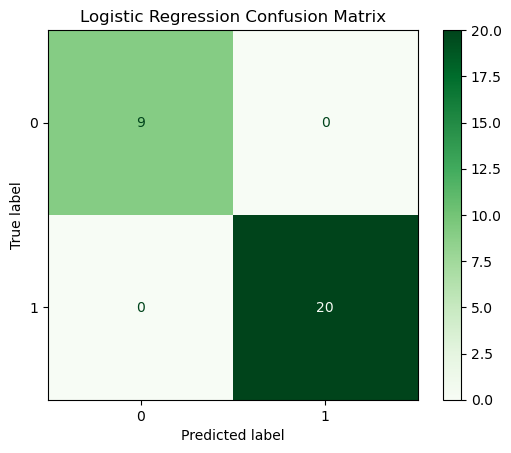

In [23]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt



# 逻辑回归混淆矩阵
lr_y_pred_bin = lr_model.predict(X_test)
lr_cm = confusion_matrix(Y_test, lr_y_pred_bin)
# 绘制逻辑回归混淆矩阵
lr_cm=plot_confusion_matrix(lr_model, X_test, Y_test, cmap='Greens')
lr_cm.ax_.set_title('Logistic Regression Confusion Matrix')
plt.savefig("0511_lr_confusion.jpg", dpi=450)
plt.show()


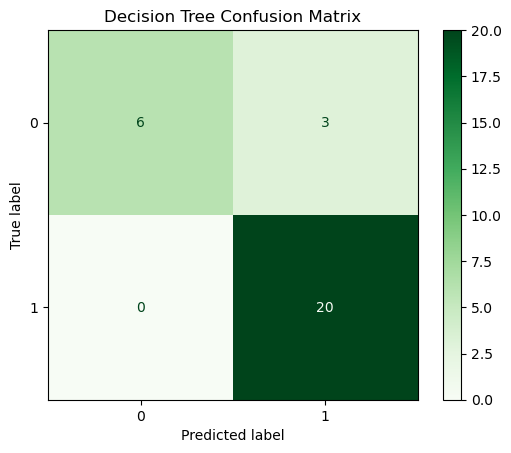

In [24]:
# 决策树混淆矩阵
dt_y_pred_bin = dt_model.predict(X_test)
dt_cm = confusion_matrix(Y_test, dt_y_pred_bin)
# 绘制决策树混淆矩阵
dt_cm = plot_confusion_matrix(dt_model, X_test, Y_test, cmap='Greens')
dt_cm.ax_.set_title('Decision Tree Confusion Matrix')
plt.savefig("0511_dt_confusion.jpg", dpi=450)
plt.show()

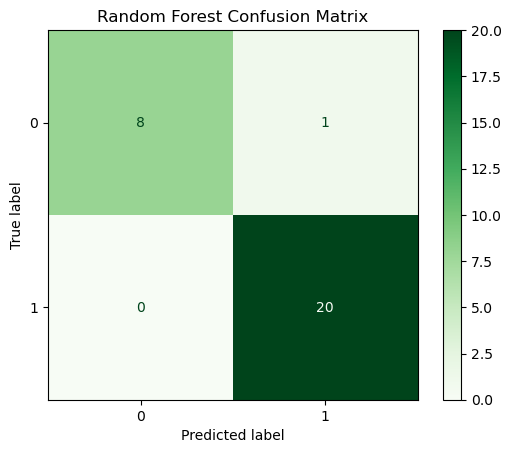

In [25]:
# 随机森林混淆矩阵
rf_y_pred_bin = rf_model.predict(X_test)
rf_cm = confusion_matrix(Y_test, rf_y_pred_bin)
# 绘制随机森林混淆矩阵
rf_cm_display = plot_confusion_matrix(rf_model, X_test, Y_test, cmap='Greens')
rf_cm_display.ax_.set_title('Random Forest Confusion Matrix')
plt.savefig("0511_rf_confusion.jpg", dpi=450)
plt.show()

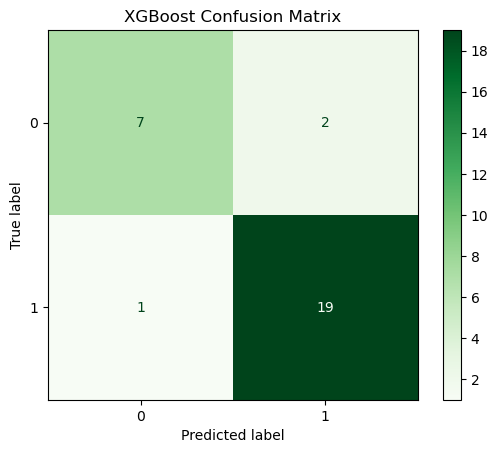

In [26]:
# XGBoost混淆矩阵
xgb_y_pred_bin = xgb_model.predict(X_test)
xgb_cm = confusion_matrix(Y_test, xgb_y_pred_bin)
# 绘制XGBoost混淆矩阵
xgb_cm_display = plot_confusion_matrix(xgb_model, X_test, Y_test, cmap='Greens')
xgb_cm_display.ax_.set_title('XGBoost Confusion Matrix')
plt.savefig("0511_xgb_confusion.jpg", dpi=450)
plt.show()

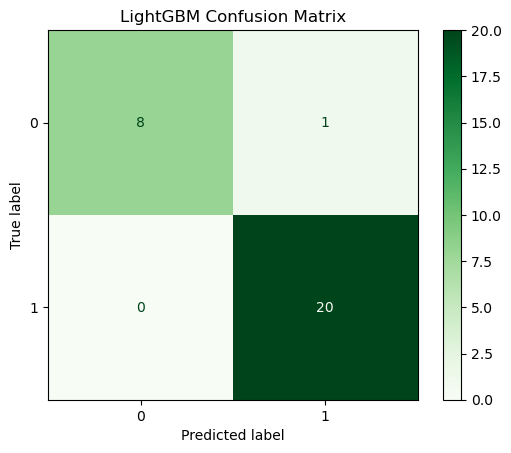

In [27]:
# LightGBM混淆矩阵
lgb_y_pred_bin = lgb_model.predict(X_test)
lgb_cm = confusion_matrix(Y_test, lgb_y_pred_bin)
# 绘制LightGBM混淆矩阵
lgb_cm = plot_confusion_matrix(lgb_model, X_test, Y_test, cmap='Greens')
lgb_cm.ax_.set_title('LightGBM Confusion Matrix')
plt.savefig("0511_lgb_confusion.jpg", dpi=450)
plt.show()

# 输出表格评估结果

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 对测试集进行预测
lr_pred = lr_model.predict(X_test)
dt_pred = dt_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)

# 计算准确率
lr_accuracy = accuracy_score(Y_test, lr_pred)
dt_accuracy = accuracy_score(Y_test, dt_pred)
rf_accuracy = accuracy_score(Y_test, rf_pred)
xgb_accuracy = accuracy_score(Y_test, xgb_pred)
lgb_accuracy = accuracy_score(Y_test, lgb_pred)

# 计算精确率
lr_precision = precision_score(Y_test, lr_pred)
dt_precision = precision_score(Y_test, dt_pred)
rf_precision = precision_score(Y_test, rf_pred)
xgb_precision = precision_score(Y_test, xgb_pred)
lgb_precision = precision_score(Y_test, lgb_pred)

# 计算召回率
lr_recall = recall_score(Y_test, lr_pred)
dt_recall = recall_score(Y_test, dt_pred)
rf_recall = recall_score(Y_test, rf_pred)
xgb_recall = recall_score(Y_test, xgb_pred)
lgb_recall = recall_score(Y_test, lgb_pred)

# 计算 F1 分数
lr_f1_score = f1_score(Y_test, lr_pred)
dt_f1_score = f1_score(Y_test, dt_pred)
rf_f1_score = f1_score(Y_test, rf_pred)
xgb_f1_score = f1_score(Y_test, xgb_pred)
lgb_f1_score = f1_score(Y_test, lgb_pred)

# 计算 AUC-ROC
lr_auc_roc = roc_auc_score(Y_test, lr_pred)
dt_auc_roc = roc_auc_score(Y_test, dt_pred)
rf_auc_roc = roc_auc_score(Y_test, rf_pred)
xgb_auc_roc = roc_auc_score(Y_test, xgb_pred)
lgb_auc_roc = roc_auc_score(Y_test, lgb_pred)

# 打印评估结果
print("逻辑回归的准确率：", lr_accuracy)
print("决策树的准确率：", dt_accuracy)
print("随机森林的准确率：", rf_accuracy)
print("XGBoost 的准确率：", xgb_accuracy)
print("LightGBM 的准确率：", lgb_accuracy)
print("---")
print("逻辑回归的精确率：", lr_precision)
print("决策树的精确率：", dt_precision)
print("随机森林的精确率：", rf_precision)
print("XGBoost 的精确率：", xgb_precision)
print("LightGBM 的精确率：", lgb_precision)
# 继续计算召回率、F1 分数


逻辑回归的准确率： 0.9310344827586207
决策树的准确率： 0.896551724137931
随机森林的准确率： 0.9655172413793104
XGBoost 的准确率： 0.896551724137931
LightGBM 的准确率： 0.9655172413793104
---
逻辑回归的精确率： 0.95
决策树的精确率： 0.8695652173913043
随机森林的精确率： 0.9523809523809523
XGBoost 的精确率： 0.9047619047619048
LightGBM 的精确率： 0.9523809523809523


In [13]:
import numpy as np

# 计算评估指标的均值和标准差
lr_accuracy_mean, lr_accuracy_sd = np.mean(lr_accuracy), np.std(lr_accuracy)
dt_accuracy_mean, dt_accuracy_sd = np.mean(dt_accuracy), np.std(dt_accuracy)
rf_accuracy_mean, rf_accuracy_sd = np.mean(rf_accuracy), np.std(rf_accuracy)
xgb_accuracy_mean, xgb_accuracy_sd = np.mean(xgb_accuracy), np.std(xgb_accuracy)
lgb_accuracy_mean, lgb_accuracy_sd = np.mean(lgb_accuracy), np.std(lgb_accuracy)

lr_precision_mean, lr_precision_sd = np.mean(lr_precision), np.std(lr_precision)
dt_precision_mean, dt_precision_sd = np.mean(dt_precision), np.std(dt_precision)
rf_precision_mean, rf_precision_sd = np.mean(rf_precision), np.std(rf_precision)
xgb_precision_mean, xgb_precision_sd = np.mean(xgb_precision), np.std(xgb_precision)
lgb_precision_mean, lgb_precision_sd = np.mean(lgb_precision), np.std(lgb_precision)

lr_recall_mean, lr_recall_sd = np.mean(lr_recall), np.std(lr_recall)
dt_recall_mean, dt_recall_sd = np.mean(dt_recall), np.std(dt_recall)
rf_recall_mean, rf_recall_sd = np.mean(rf_recall), np.std(rf_recall)
xgb_recall_mean, xgb_recall_sd = np.mean(xgb_recall), np.std(xgb_recall)
lgb_recall_mean, lgb_recall_sd = np.mean(lgb_recall), np.std(lgb_recall)

lr_f1_score_mean, lr_f1_score_sd = np.mean(lr_f1_score), np.std(lr_f1_score)
dt_f1_score_mean, dt_f1_score_sd = np.mean(dt_f1_score), np.std(dt_f1_score)
rf_f1_score_mean, rf_f1_score_sd = np.mean(rf_f1_score), np.std(rf_f1_score)
xgb_f1_score_mean, xgb_f1_score_sd = np.mean(xgb_f1_score), np.std(xgb_f1_score)
lgb_f1_score_mean, lgb_f1_score_sd = np.mean(lgb_f1_score), np.std(lgb_f1_score)

lr_auc_roc_mean, lr_auc_roc_sd = np.mean(lr_auc_roc), np.std(lr_auc_roc)
dt_auc_roc_mean, dt_auc_roc_sd = np.mean(dt_auc_roc), np.std(dt_auc_roc)
rf_auc_roc_mean, rf_auc_roc_sd = np.mean(rf_auc_roc), np.std(rf_auc_roc)
xgb_auc_roc_mean, xgb_auc_roc_sd = np.mean(xgb_auc_roc), np.std(xgb_auc_roc)
lgb_auc_roc_mean, lgb_auc_roc_sd = np.mean(lgb_auc_roc), np.std(lgb_auc_roc)

# 打印评估结果
print("逻辑回归的准确率：{:.2f} ± {:.2f}".format(lr_accuracy_mean, lr_accuracy_sd))
print("决策树的准确率：{:.2f} ± {:.2f}".format(dt_accuracy_mean, dt_accuracy_sd))
print("随机森林的准确率：{:.2f} ± {:.2f}".format(rf_accuracy_mean, rf_accuracy_sd))
print("XGBoost 的准确率：{:.2f} ± {:.2f}".format(xgb_accuracy_mean, xgb_accuracy_sd))
print("LightGBM 的准确率：{:.2f} ± {:.2f}".format(lgb_accuracy_mean, lgb_accuracy_sd))
print("---")
print("逻辑回归的精确率：{:.2f} ± {:.2f}".format(lr_precision_mean, lr_precision_sd))
print("决策树的精确率：{:.2f} ± {:.2f}".format(dt_precision_mean, dt_precision_sd))
print("随机森林的精确率：{:.2f} ± {:.2f}".format(rf_precision_mean, rf_precision_sd))
print("XGBoost 的精确率：{:.2f} ± {:.2f}".format(xgb_precision_mean, xgb_precision_sd))
print("LightGBM 的精确率：{:.2f} ± {:.2f}".format(lgb_precision_mean, lgb_precision_sd))
print("---")
print("逻辑回归的召回率：{:.2f} ± {:.2f}".format(lr_recall_mean, lr_recall_sd))
print("决策树的召回率：{:.2f} ± {:.2f}".format(dt_recall_mean, dt_recall_sd))
print("随机森林的召回率：{:.2f} ± {:.2f}".format(rf_recall_mean, rf_recall_sd))
print("XGBoost 的召回率：{:.2f} ± {:.2f}".format(xgb_recall_mean, xgb_recall_sd))
print("LightGBM 的召回率：{:.2f} ± {:.2f}".format(lgb_recall_mean, lgb_recall_sd))
print("---")
print("逻辑回归的F1 分数：{:.2f} ± {:.2f}".format(lr_f1_score_mean, lr_f1_score_sd))
print("决策树的F1 分数：{:.2f} ± {:.2f}".format(dt_f1_score_mean, dt_f1_score_sd))
print("随机森林的F1 分数：{:.2f} ± {:.2f}".format(rf_f1_score_mean, rf_f1_score_sd))
print("XGBoost 的F1 分数：{:.2f} ± {:.2f}".format(xgb_f1_score_mean, xgb_f1_score_sd))
print("LightGBM 的F1 分数：{:.2f} ± {:.2f}".format(lgb_f1_score_mean, lgb_f1_score_sd))
print("---")
print("逻辑回归的AUC-ROC：{:.2f} ± {:.2f}".format(lr_auc_roc_mean, lr_auc_roc_sd))
print("决策树的AUC-ROC：{:.2f} ± {:.2f}".format(dt_auc_roc_mean, dt_auc_roc_sd))
print("随机森林的AUC-ROC：{:.2f} ± {:.2f}".format(rf_auc_roc_mean, rf_auc_roc_sd))
print("XGBoost 的AUC-ROC：{:.2f} ± {:.2f}".format(xgb_auc_roc_mean, xgb_auc_roc_sd))
print("LightGBM 的AUC-ROC：{:.2f} ± {:.2f}".format(lgb_auc_roc_mean, lgb_auc_roc_sd))



逻辑回归的准确率：0.93 ± 0.00
决策树的准确率：0.90 ± 0.00
随机森林的准确率：0.97 ± 0.00
XGBoost 的准确率：0.90 ± 0.00
LightGBM 的准确率：0.97 ± 0.00
---
逻辑回归的精确率：0.95 ± 0.00
决策树的精确率：0.87 ± 0.00
随机森林的精确率：0.95 ± 0.00
XGBoost 的精确率：0.90 ± 0.00
LightGBM 的精确率：0.95 ± 0.00
---
逻辑回归的召回率：0.95 ± 0.00
决策树的召回率：1.00 ± 0.00
随机森林的召回率：1.00 ± 0.00
XGBoost 的召回率：0.95 ± 0.00
LightGBM 的召回率：1.00 ± 0.00
---
逻辑回归的F1 分数：0.95 ± 0.00
决策树的F1 分数：0.93 ± 0.00
随机森林的F1 分数：0.98 ± 0.00
XGBoost 的F1 分数：0.93 ± 0.00
LightGBM 的F1 分数：0.98 ± 0.00
---
逻辑回归的AUC-ROC：0.92 ± 0.00
决策树的AUC-ROC：0.83 ± 0.00
随机森林的AUC-ROC：0.94 ± 0.00
XGBoost 的AUC-ROC：0.86 ± 0.00
LightGBM 的AUC-ROC：0.94 ± 0.00


In [14]:
import pandas as pd

# Create DataFrame with evaluation results
data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Accuracy': ["{:.2f} ± {:.2f}".format(lr_accuracy_mean, lr_accuracy_sd),
                 "{:.2f} ± {:.2f}".format(dt_accuracy_mean, dt_accuracy_sd),
                 "{:.2f} ± {:.2f}".format(rf_accuracy_mean, rf_accuracy_sd),
                 "{:.2f} ± {:.2f}".format(xgb_accuracy_mean, xgb_accuracy_sd),
                 "{:.2f} ± {:.2f}".format(lgb_accuracy_mean, lgb_accuracy_sd)],
    'Precision': ["{:.2f} ± {:.2f}".format(lr_precision_mean, lr_precision_sd),
                  "{:.2f} ± {:.2f}".format(dt_precision_mean, dt_precision_sd),
                  "{:.2f} ± {:.2f}".format(rf_precision_mean, rf_precision_sd),
                  "{:.2f} ± {:.2f}".format(xgb_precision_mean, xgb_precision_sd),
                  "{:.2f} ± {:.2f}".format(lgb_precision_mean, lgb_precision_sd)],
    'Recall': ["{:.2f} ± {:.2f}".format(lr_recall_mean, lr_recall_sd),
               "{:.2f} ± {:.2f}".format(dt_recall_mean, dt_recall_sd),
               "{:.2f} ± {:.2f}".format(rf_recall_mean, rf_recall_sd),
               "{:.2f} ± {:.2f}".format(xgb_recall_mean, xgb_recall_sd),
               "{:.2f} ± {:.2f}".format(lgb_recall_mean, lgb_recall_sd)],
    'F1 Score': ["{:.2f} ± {:.2f}".format(lr_f1_score_mean, lr_f1_score_sd),
                 "{:.2f} ± {:.2f}".format(dt_f1_score_mean, dt_f1_score_sd),
                 "{:.2f} ± {:.2f}".format(rf_f1_score_mean, rf_f1_score_sd),
                 "{:.2f} ± {:.2f}".format(xgb_f1_score_mean, xgb_f1_score_sd),
                 "{:.2f} ± {:.2f}".format(lgb_f1_score_mean, lgb_f1_score_sd)],
    'AUC-ROC': ["{:.2f} ± {:.2f}".format(lr_auc_roc_mean, lr_auc_roc_sd),
                "{:.2f} ± {:.2f}".format(dt_auc_roc_mean, dt_auc_roc_sd),
                "{:.2f} ± {:.2f}".format(rf_auc_roc_mean, rf_auc_roc_sd),
                "{:.2f} ± {:.2f}".format(xgb_auc_roc_mean, xgb_auc_roc_sd),
                "{:.2f} ± {:.2f}".format(lgb_auc_roc_mean, lgb_auc_roc_sd)]
}

df = pd.DataFrame(data)

# Export DataFrame as CSV
df.to_csv('0511_evaluation_results.csv', index=False)


# sharp模型选择关键基因

In [54]:
import shap 
from pdpbox import pdp, info_plots 
np.random.seed(2022) 

pd.options.mode.chained_assignment = None  
%matplotlib inline

[0.         0.         0.         0.         0.00689655 0.
 0.03448276 0.         0.         0.         0.02068966 0.
 0.         0.00689655 0.         0.02068966 0.         0.0137931
 0.00689655 0.         0.         0.         0.00689655 0.02758621
 0.05517241 0.         0.         0.0137931  0.         0.
 0.         0.         0.         0.00689655 0.0137931  0.03448276
 0.         0.         0.         0.         0.         0.
 0.02758621 0.         0.         0.         0.         0.
 0.         0.         0.         0.03448276 0.         0.
 0.         0.         0.         0.         0.03448276 0.02068966
 0.         0.         0.         0.0137931  0.         0.
 0.         0.02758621 0.02758621 0.         0.         0.
 0.         0.         0.         0.03448276 0.         0.
 0.         0.         0.         0.         0.         0.00689655
 0.         0.0137931  0.05517241 0.02758621 0.         0.
 0.         0.         0.         0.         0.00689655 0.
 0.         0.   

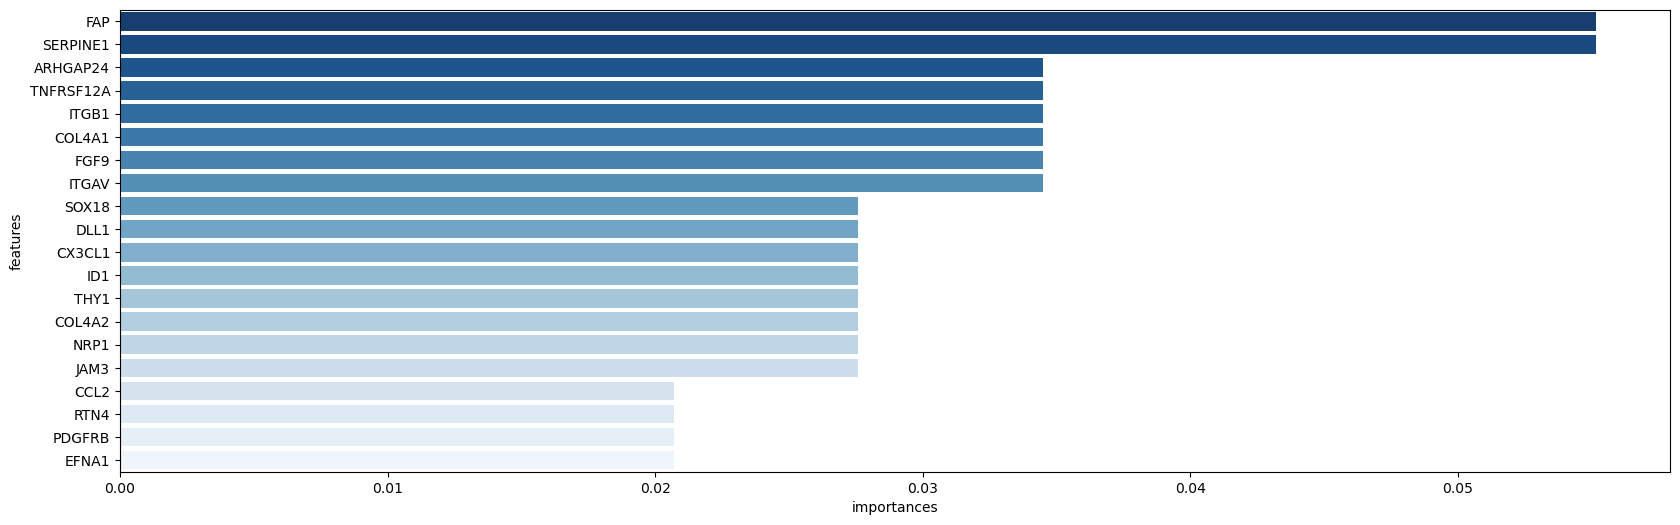

In [66]:
from sklearn.inspection import permutation_importance
import eli5

# 逻辑回归模型
# 计算每个变量对模型的重要性
perm = permutation_importance(lr_model, X_test, Y_test, random_state=10)
feature_importances = perm.importances_mean

# 显示变量重要性权重
eli5.show_weights(perm, feature_names=X_test.columns.tolist())
# 打印特征排序均值
print(feature_importances)

# 可视化前10个重要特征
import matplotlib.pyplot as plt
import seaborn as sns
features = X.columns
data_tuples = list(zip(feature_importances, features))
data = pd.DataFrame(data_tuples, columns=['importances', 'features'])
data = data.sort_values('importances', ascending=False)[:20]

plt.figure(figsize=(20, 6))
ax = sns.barplot(x=data['importances'], y=data['features'], palette="Blues_r", orient='h')
plt.savefig("0512_barplot.pdf")
data.to_csv('0512_dataimportance.csv')



In [69]:
import shap
import eli5
from sklearn.inspection import permutation_importance
import xgboost as xgb
import lightgbm as lgb

# summary_plot
# summarize the effects of all the features


# SHAP
import shap
# 创建SHAP解释器
explainer = shap.KernelExplainer(lr_model.predict_proba, X_train)
# 计算SHAP值
shap_values = explainer.shap_values(X_test)
# 显示SHAP值
print(shap_values)
#shap可视化
shap.summary_plot(shap_values[1],X_test,plot_type="bar")
plt.savefig('0512_shap_values1.png')

Using 116 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/29 [00:00<?, ?it/s]

[array([[ 0.        ,  0.        ,  0.00213147, ...,  0.00127261,
         0.        ,  0.00048105],
       [ 0.        , -0.00022905,  0.00068018, ...,  0.        ,
        -0.00122686, -0.00158018],
       [ 0.00310317,  0.00211216,  0.        , ..., -0.00279965,
        -0.00316699,  0.        ],
       ...,
       [ 0.00103116, -0.00046491,  0.        , ..., -0.00053136,
        -0.00029339,  0.00079692],
       [-0.00091453, -0.00123451,  0.00322433, ...,  0.        ,
         0.        ,  0.00123771],
       [-0.00135685,  0.        , -0.0009264 , ..., -0.0045525 ,
        -0.00347843,  0.00044163]]), array([[ 0.        ,  0.        , -0.00213147, ..., -0.00127261,
         0.        , -0.00048105],
       [ 0.        ,  0.00022905, -0.00068018, ...,  0.        ,
         0.00122686,  0.00158018],
       [-0.00310317, -0.00211216,  0.        , ...,  0.00279965,
         0.00316699,  0.        ],
       ...,
       [-0.00103116,  0.00046491,  0.        , ...,  0.00053136,
        

Using 116 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/29 [00:00<?, ?it/s]

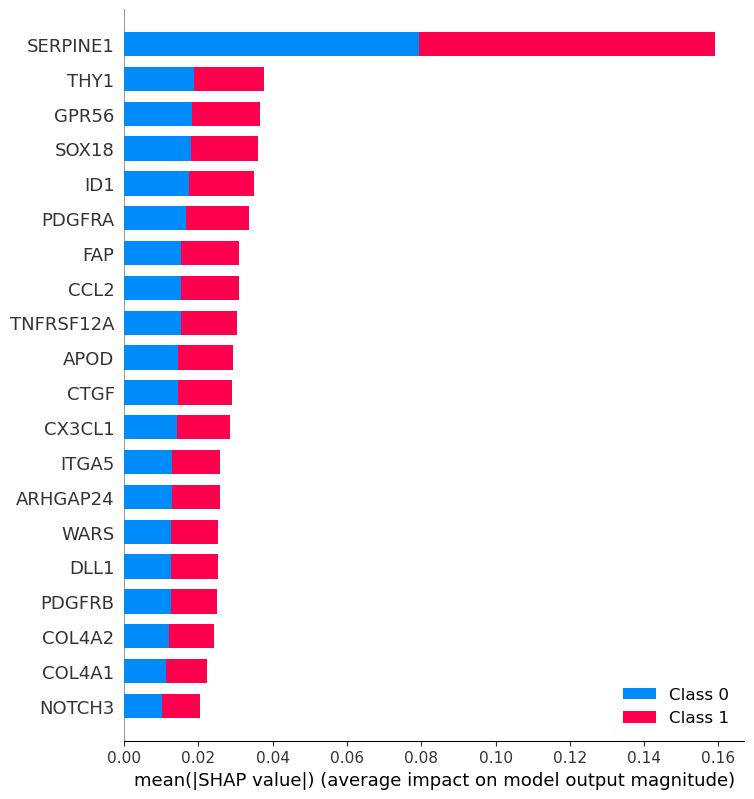

In [77]:
# 全局条形图
# 特征重要性的条形图还有另一种绘制方法。
# 输出shap.Explanation对象
# compute SHAP values
# 创建SHAP解释器
explainer = shap.KernelExplainer(lr_model.predict_proba, X_train)
# 计算SHAP值
shap_values2 = explainer.shap_values(X_test, check_additivity=False)
# 显示SHAP值
figure = plt.figure(figsize=(16,10))
shap.summary_plot(shap_values2, X_test, plot_type='bar', max_display=20, show=False)
plt.savefig("0512_shap_values2.jpg")


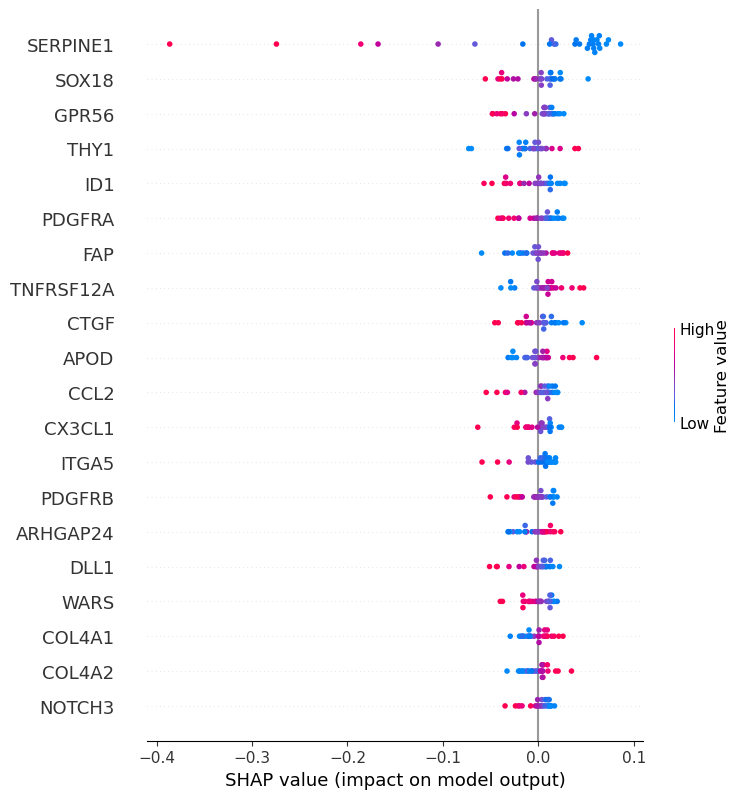

In [87]:
shap.summary_plot(shap_values[1],X_test)
# 转换为DataFrame并选择前20行进行打印
# 选择特定的目标类别
target_class = 1
# 转换为DataFrame并选择前20行进行打印
shap_df = pd.DataFrame(shap_values[target_class], columns=X_test.columns)
top20_shap_df = shap_df.head(20)
top20_shap_df.to_csv('top20_shap_values.csv', index=False)

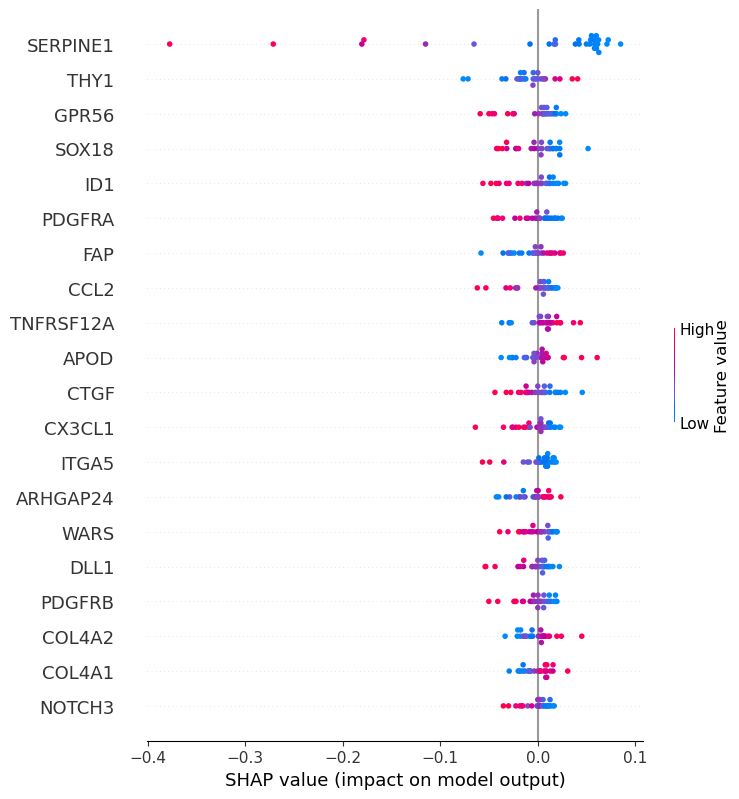

In [88]:
shap.summary_plot(shap_values2[1],X_test)
# 转换为DataFrame并选择前20行进行打印
# 选择特定的目标类别
target_class = 1
# 转换为DataFrame并选择前20行进行打印
shap_df = pd.DataFrame(shap_values2[target_class], columns=X_test.columns)
top20_shap_df = shap_df.head(20)
top20_shap_df.to_csv('top20_shap_values2.csv', index=False)

# 筛选分类学习模型

In [107]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# 2 筛选机器学习模型
SEED=2022
models = [
    LogisticRegression(random_state=SEED),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=SEED),
    LinearDiscriminantAnalysis(),
    MLPClassifier(random_state=SEED),
    SVC(random_state=SEED),
    DecisionTreeClassifier(random_state=SEED),
    ExtraTreesClassifier(random_state=SEED),
    GradientBoostingClassifier(random_state=SEED),
    BaggingClassifier(random_state=SEED),
    AdaBoostClassifier(random_state=SEED)
]

# 创建评估指标列表
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1_score': 'f1',
    'auc_roc': 'roc_auc'
}

# 执行交叉验证和模型评估
results = []
for model in models:
    cv_results = cross_validate(model, X_train, Y_train, cv=5, scoring=scoring)
    result = {
        'model': type(model).__name__,
        'accuracy_mean': cv_results['test_accuracy'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std(),
        'precision_mean': cv_results['test_precision'].mean(),
        'precision_std': cv_results['test_precision'].std(),
        'recall_mean': cv_results['test_recall'].mean(),
        'recall_std': cv_results['test_recall'].std(),
        'f1_score_mean': cv_results['test_f1_score'].mean(),
        'f1_score_std': cv_results['test_f1_score'].std(),
        'auc_roc_mean': cv_results['test_auc_roc'].mean(),
        'auc_roc_std': cv_results['test_auc_roc'].std()
    }
    results.append(result)

# 将结果导出为CSV文件
results_df = pd.DataFrame(results)
results_df.to_csv('model_evaluation_results.csv', index=False)

In [132]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 创建模型列表
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    SVC(),
    GaussianNB(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    xgb.XGBClassifier(),
    lgb.LGBMClassifier(),
    CatBoostClassifier()
]

# 创建评估指标列表
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1_score': 'f1',
    'auc_roc': 'roc_auc'
}

# 执行交叉验证和模型评估
results = []
for model in models:
    cv_results = cross_validate(model, X_train, Y_train, cv=5, scoring=scoring)
    result = {
        'model': type(model).__name__,
        'accuracy_mean': cv_results['test_accuracy'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std(),
        'precision_mean': cv_results['test_precision'].mean(),
        'precision_std': cv_results['test_precision'].std(),
        'recall_mean': cv_results['test_recall'].mean(),
        'recall_std': cv_results['test_recall'].std(),
        'f1_score_mean': cv_results['test_f1_score'].mean(),
        'f1_score_std': cv_results['test_f1_score'].std(),
        'auc_roc_mean': cv_results['test_auc_roc'].mean(),
        'auc_roc_std': cv_results['test_auc_roc'].std()
    }
    results.append(result)

# 将结果导出为CSV文件
results_df = pd.DataFrame(results)
results_df.to_csv('0512_model_evaluation_results.csv', index=False)


[11:18:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:07] WARNING: /home

147:	learn: 0.3528078	total: 1.19s	remaining: 6.84s
148:	learn: 0.3510848	total: 1.2s	remaining: 6.83s
149:	learn: 0.3492494	total: 1.2s	remaining: 6.83s
150:	learn: 0.3478082	total: 1.21s	remaining: 6.82s
151:	learn: 0.3462660	total: 1.22s	remaining: 6.8s
152:	learn: 0.3443214	total: 1.23s	remaining: 6.79s
153:	learn: 0.3431070	total: 1.23s	remaining: 6.78s
154:	learn: 0.3418354	total: 1.24s	remaining: 6.77s
155:	learn: 0.3408934	total: 1.25s	remaining: 6.76s
156:	learn: 0.3395691	total: 1.26s	remaining: 6.75s
157:	learn: 0.3384474	total: 1.26s	remaining: 6.74s
158:	learn: 0.3372883	total: 1.27s	remaining: 6.73s
159:	learn: 0.3358617	total: 1.28s	remaining: 6.72s
160:	learn: 0.3348715	total: 1.29s	remaining: 6.71s
161:	learn: 0.3335451	total: 1.29s	remaining: 6.7s
162:	learn: 0.3320790	total: 1.3s	remaining: 6.69s
163:	learn: 0.3309058	total: 1.31s	remaining: 6.68s
164:	learn: 0.3295984	total: 1.32s	remaining: 6.67s
165:	learn: 0.3276778	total: 1.33s	remaining: 6.66s
166:	learn: 0.326

307:	learn: 0.2015414	total: 2.39s	remaining: 5.38s
308:	learn: 0.2009764	total: 2.4s	remaining: 5.37s
309:	learn: 0.2002257	total: 2.41s	remaining: 5.36s
310:	learn: 0.1995838	total: 2.42s	remaining: 5.35s
311:	learn: 0.1988986	total: 2.42s	remaining: 5.34s
312:	learn: 0.1983803	total: 2.43s	remaining: 5.34s
313:	learn: 0.1977160	total: 2.44s	remaining: 5.33s
314:	learn: 0.1970438	total: 2.45s	remaining: 5.32s
315:	learn: 0.1964963	total: 2.45s	remaining: 5.31s
316:	learn: 0.1957743	total: 2.46s	remaining: 5.3s
317:	learn: 0.1952215	total: 2.47s	remaining: 5.3s
318:	learn: 0.1943877	total: 2.48s	remaining: 5.29s
319:	learn: 0.1937049	total: 2.48s	remaining: 5.28s
320:	learn: 0.1931572	total: 2.49s	remaining: 5.27s
321:	learn: 0.1925978	total: 2.5s	remaining: 5.26s
322:	learn: 0.1921463	total: 2.51s	remaining: 5.25s
323:	learn: 0.1914605	total: 2.52s	remaining: 5.25s
324:	learn: 0.1908843	total: 2.52s	remaining: 5.24s
325:	learn: 0.1902109	total: 2.53s	remaining: 5.23s
326:	learn: 0.18

470:	learn: 0.1269471	total: 3.62s	remaining: 4.06s
471:	learn: 0.1266457	total: 3.62s	remaining: 4.05s
472:	learn: 0.1263480	total: 3.63s	remaining: 4.04s
473:	learn: 0.1260040	total: 3.64s	remaining: 4.04s
474:	learn: 0.1258565	total: 3.65s	remaining: 4.03s
475:	learn: 0.1255430	total: 3.65s	remaining: 4.02s
476:	learn: 0.1252300	total: 3.66s	remaining: 4.01s
477:	learn: 0.1249992	total: 3.67s	remaining: 4s
478:	learn: 0.1247104	total: 3.67s	remaining: 4s
479:	learn: 0.1242847	total: 3.68s	remaining: 3.99s
480:	learn: 0.1240082	total: 3.69s	remaining: 3.98s
481:	learn: 0.1235702	total: 3.7s	remaining: 3.97s
482:	learn: 0.1232845	total: 3.7s	remaining: 3.96s
483:	learn: 0.1229526	total: 3.71s	remaining: 3.96s
484:	learn: 0.1224950	total: 3.72s	remaining: 3.95s
485:	learn: 0.1222213	total: 3.73s	remaining: 3.94s
486:	learn: 0.1219137	total: 3.73s	remaining: 3.93s
487:	learn: 0.1216062	total: 3.74s	remaining: 3.93s
488:	learn: 0.1213546	total: 3.75s	remaining: 3.92s
489:	learn: 0.121132

632:	learn: 0.0874231	total: 4.83s	remaining: 2.8s
633:	learn: 0.0872163	total: 4.83s	remaining: 2.79s
634:	learn: 0.0870233	total: 4.84s	remaining: 2.78s
635:	learn: 0.0868426	total: 4.85s	remaining: 2.77s
636:	learn: 0.0866123	total: 4.86s	remaining: 2.77s
637:	learn: 0.0864057	total: 4.86s	remaining: 2.76s
638:	learn: 0.0862238	total: 4.87s	remaining: 2.75s
639:	learn: 0.0859572	total: 4.88s	remaining: 2.74s
640:	learn: 0.0858117	total: 4.89s	remaining: 2.74s
641:	learn: 0.0856873	total: 4.89s	remaining: 2.73s
642:	learn: 0.0855260	total: 4.9s	remaining: 2.72s
643:	learn: 0.0852731	total: 4.91s	remaining: 2.71s
644:	learn: 0.0850935	total: 4.92s	remaining: 2.71s
645:	learn: 0.0849227	total: 4.92s	remaining: 2.7s
646:	learn: 0.0847496	total: 4.93s	remaining: 2.69s
647:	learn: 0.0845294	total: 4.94s	remaining: 2.68s
648:	learn: 0.0843525	total: 4.95s	remaining: 2.67s
649:	learn: 0.0841382	total: 4.95s	remaining: 2.67s
650:	learn: 0.0839532	total: 4.96s	remaining: 2.66s
651:	learn: 0.0

794:	learn: 0.0631829	total: 6.04s	remaining: 1.56s
795:	learn: 0.0630651	total: 6.05s	remaining: 1.55s
796:	learn: 0.0629073	total: 6.06s	remaining: 1.54s
797:	learn: 0.0628275	total: 6.07s	remaining: 1.53s
798:	learn: 0.0627462	total: 6.07s	remaining: 1.53s
799:	learn: 0.0626532	total: 6.08s	remaining: 1.52s
800:	learn: 0.0624838	total: 6.09s	remaining: 1.51s
801:	learn: 0.0623933	total: 6.09s	remaining: 1.5s
802:	learn: 0.0623027	total: 6.1s	remaining: 1.5s
803:	learn: 0.0621961	total: 6.11s	remaining: 1.49s
804:	learn: 0.0620789	total: 6.12s	remaining: 1.48s
805:	learn: 0.0619638	total: 6.13s	remaining: 1.47s
806:	learn: 0.0618120	total: 6.13s	remaining: 1.47s
807:	learn: 0.0617265	total: 6.14s	remaining: 1.46s
808:	learn: 0.0616066	total: 6.15s	remaining: 1.45s
809:	learn: 0.0614638	total: 6.16s	remaining: 1.44s
810:	learn: 0.0613977	total: 6.16s	remaining: 1.44s
811:	learn: 0.0612825	total: 6.17s	remaining: 1.43s
812:	learn: 0.0611812	total: 6.18s	remaining: 1.42s
813:	learn: 0.0

956:	learn: 0.0479548	total: 7.26s	remaining: 326ms
957:	learn: 0.0478616	total: 7.27s	remaining: 319ms
958:	learn: 0.0477698	total: 7.28s	remaining: 311ms
959:	learn: 0.0477046	total: 7.28s	remaining: 303ms
960:	learn: 0.0476396	total: 7.29s	remaining: 296ms
961:	learn: 0.0475569	total: 7.3s	remaining: 288ms
962:	learn: 0.0474463	total: 7.3s	remaining: 281ms
963:	learn: 0.0473941	total: 7.31s	remaining: 273ms
964:	learn: 0.0473270	total: 7.32s	remaining: 265ms
965:	learn: 0.0472127	total: 7.33s	remaining: 258ms
966:	learn: 0.0471299	total: 7.33s	remaining: 250ms
967:	learn: 0.0470577	total: 7.34s	remaining: 243ms
968:	learn: 0.0469827	total: 7.35s	remaining: 235ms
969:	learn: 0.0468790	total: 7.36s	remaining: 228ms
970:	learn: 0.0468077	total: 7.36s	remaining: 220ms
971:	learn: 0.0467261	total: 7.37s	remaining: 212ms
972:	learn: 0.0466682	total: 7.38s	remaining: 205ms
973:	learn: 0.0465858	total: 7.39s	remaining: 197ms
974:	learn: 0.0465308	total: 7.39s	remaining: 190ms
975:	learn: 0.

134:	learn: 0.3548030	total: 1.01s	remaining: 6.49s
135:	learn: 0.3531142	total: 1.02s	remaining: 6.49s
136:	learn: 0.3515294	total: 1.03s	remaining: 6.48s
137:	learn: 0.3504228	total: 1.04s	remaining: 6.47s
138:	learn: 0.3489136	total: 1.04s	remaining: 6.46s
139:	learn: 0.3475029	total: 1.05s	remaining: 6.46s
140:	learn: 0.3456597	total: 1.06s	remaining: 6.45s
141:	learn: 0.3440788	total: 1.07s	remaining: 6.44s
142:	learn: 0.3427752	total: 1.07s	remaining: 6.44s
143:	learn: 0.3412102	total: 1.08s	remaining: 6.43s
144:	learn: 0.3393890	total: 1.09s	remaining: 6.42s
145:	learn: 0.3374264	total: 1.1s	remaining: 6.42s
146:	learn: 0.3361196	total: 1.1s	remaining: 6.41s
147:	learn: 0.3344275	total: 1.11s	remaining: 6.4s
148:	learn: 0.3329858	total: 1.12s	remaining: 6.4s
149:	learn: 0.3319203	total: 1.13s	remaining: 6.39s
150:	learn: 0.3308589	total: 1.14s	remaining: 6.38s
151:	learn: 0.3297535	total: 1.14s	remaining: 6.37s
152:	learn: 0.3283188	total: 1.15s	remaining: 6.37s
153:	learn: 0.32

295:	learn: 0.1886289	total: 2.22s	remaining: 5.29s
296:	learn: 0.1877736	total: 2.23s	remaining: 5.28s
297:	learn: 0.1871344	total: 2.24s	remaining: 5.27s
298:	learn: 0.1865046	total: 2.25s	remaining: 5.26s
299:	learn: 0.1860936	total: 2.25s	remaining: 5.26s
300:	learn: 0.1855732	total: 2.26s	remaining: 5.25s
301:	learn: 0.1848718	total: 2.27s	remaining: 5.24s
302:	learn: 0.1843026	total: 2.27s	remaining: 5.23s
303:	learn: 0.1835546	total: 2.28s	remaining: 5.22s
304:	learn: 0.1827758	total: 2.29s	remaining: 5.22s
305:	learn: 0.1820103	total: 2.3s	remaining: 5.21s
306:	learn: 0.1815204	total: 2.3s	remaining: 5.2s
307:	learn: 0.1808443	total: 2.31s	remaining: 5.19s
308:	learn: 0.1801113	total: 2.32s	remaining: 5.19s
309:	learn: 0.1793564	total: 2.33s	remaining: 5.18s
310:	learn: 0.1786718	total: 2.33s	remaining: 5.17s
311:	learn: 0.1780157	total: 2.34s	remaining: 5.16s
312:	learn: 0.1775287	total: 2.35s	remaining: 5.16s
313:	learn: 0.1770134	total: 2.36s	remaining: 5.15s
314:	learn: 0.1

456:	learn: 0.1152352	total: 3.44s	remaining: 4.09s
457:	learn: 0.1149889	total: 3.45s	remaining: 4.09s
458:	learn: 0.1146905	total: 3.46s	remaining: 4.08s
459:	learn: 0.1143074	total: 3.47s	remaining: 4.07s
460:	learn: 0.1139324	total: 3.48s	remaining: 4.06s
461:	learn: 0.1136710	total: 3.48s	remaining: 4.06s
462:	learn: 0.1133186	total: 3.49s	remaining: 4.05s
463:	learn: 0.1129966	total: 3.5s	remaining: 4.04s
464:	learn: 0.1127258	total: 3.5s	remaining: 4.03s
465:	learn: 0.1124478	total: 3.51s	remaining: 4.03s
466:	learn: 0.1120047	total: 3.52s	remaining: 4.02s
467:	learn: 0.1117588	total: 3.53s	remaining: 4.01s
468:	learn: 0.1113040	total: 3.54s	remaining: 4s
469:	learn: 0.1110202	total: 3.54s	remaining: 4s
470:	learn: 0.1107070	total: 3.55s	remaining: 3.99s
471:	learn: 0.1103371	total: 3.56s	remaining: 3.98s
472:	learn: 0.1101047	total: 3.57s	remaining: 3.97s
473:	learn: 0.1097182	total: 3.57s	remaining: 3.97s
474:	learn: 0.1095506	total: 3.58s	remaining: 3.96s
475:	learn: 0.109119

622:	learn: 0.0755237	total: 4.7s	remaining: 2.85s
623:	learn: 0.0753584	total: 4.71s	remaining: 2.84s
624:	learn: 0.0752259	total: 4.72s	remaining: 2.83s
625:	learn: 0.0750830	total: 4.73s	remaining: 2.82s
626:	learn: 0.0749493	total: 4.74s	remaining: 2.82s
627:	learn: 0.0747344	total: 4.74s	remaining: 2.81s
628:	learn: 0.0746034	total: 4.75s	remaining: 2.8s
629:	learn: 0.0744378	total: 4.76s	remaining: 2.79s
630:	learn: 0.0742611	total: 4.76s	remaining: 2.79s
631:	learn: 0.0741084	total: 4.77s	remaining: 2.78s
632:	learn: 0.0739561	total: 4.78s	remaining: 2.77s
633:	learn: 0.0738022	total: 4.79s	remaining: 2.76s
634:	learn: 0.0736674	total: 4.79s	remaining: 2.76s
635:	learn: 0.0735476	total: 4.8s	remaining: 2.75s
636:	learn: 0.0733076	total: 4.81s	remaining: 2.74s
637:	learn: 0.0731726	total: 4.82s	remaining: 2.73s
638:	learn: 0.0730755	total: 4.83s	remaining: 2.73s
639:	learn: 0.0729288	total: 4.83s	remaining: 2.72s
640:	learn: 0.0727682	total: 4.84s	remaining: 2.71s
641:	learn: 0.0

783:	learn: 0.0538794	total: 5.92s	remaining: 1.63s
784:	learn: 0.0538099	total: 5.93s	remaining: 1.62s
785:	learn: 0.0537505	total: 5.93s	remaining: 1.61s
786:	learn: 0.0536671	total: 5.94s	remaining: 1.61s
787:	learn: 0.0535844	total: 5.95s	remaining: 1.6s
788:	learn: 0.0534727	total: 5.96s	remaining: 1.59s
789:	learn: 0.0533727	total: 5.96s	remaining: 1.58s
790:	learn: 0.0532961	total: 5.97s	remaining: 1.58s
791:	learn: 0.0532009	total: 5.98s	remaining: 1.57s
792:	learn: 0.0530960	total: 5.99s	remaining: 1.56s
793:	learn: 0.0529503	total: 5.99s	remaining: 1.55s
794:	learn: 0.0528452	total: 6s	remaining: 1.55s
795:	learn: 0.0527466	total: 6.01s	remaining: 1.54s
796:	learn: 0.0526699	total: 6.02s	remaining: 1.53s
797:	learn: 0.0525505	total: 6.02s	remaining: 1.52s
798:	learn: 0.0524587	total: 6.03s	remaining: 1.52s
799:	learn: 0.0523714	total: 6.04s	remaining: 1.51s
800:	learn: 0.0522956	total: 6.05s	remaining: 1.5s
801:	learn: 0.0522052	total: 6.05s	remaining: 1.49s
802:	learn: 0.052

945:	learn: 0.0400655	total: 7.13s	remaining: 407ms
946:	learn: 0.0399910	total: 7.14s	remaining: 400ms
947:	learn: 0.0399351	total: 7.15s	remaining: 392ms
948:	learn: 0.0398618	total: 7.16s	remaining: 385ms
949:	learn: 0.0398018	total: 7.17s	remaining: 377ms
950:	learn: 0.0397471	total: 7.17s	remaining: 370ms
951:	learn: 0.0397065	total: 7.18s	remaining: 362ms
952:	learn: 0.0396638	total: 7.19s	remaining: 355ms
953:	learn: 0.0396043	total: 7.2s	remaining: 347ms
954:	learn: 0.0394976	total: 7.2s	remaining: 339ms
955:	learn: 0.0394107	total: 7.21s	remaining: 332ms
956:	learn: 0.0393297	total: 7.22s	remaining: 324ms
957:	learn: 0.0392686	total: 7.22s	remaining: 317ms
958:	learn: 0.0391858	total: 7.23s	remaining: 309ms
959:	learn: 0.0391152	total: 7.24s	remaining: 302ms
960:	learn: 0.0390268	total: 7.25s	remaining: 294ms
961:	learn: 0.0389806	total: 7.25s	remaining: 287ms
962:	learn: 0.0388872	total: 7.26s	remaining: 279ms
963:	learn: 0.0388349	total: 7.27s	remaining: 271ms
964:	learn: 0.

123:	learn: 0.3960039	total: 940ms	remaining: 6.64s
124:	learn: 0.3941398	total: 948ms	remaining: 6.63s
125:	learn: 0.3924837	total: 955ms	remaining: 6.63s
126:	learn: 0.3907878	total: 963ms	remaining: 6.62s
127:	learn: 0.3887010	total: 970ms	remaining: 6.61s
128:	learn: 0.3872233	total: 978ms	remaining: 6.6s
129:	learn: 0.3853916	total: 986ms	remaining: 6.6s
130:	learn: 0.3838837	total: 994ms	remaining: 6.59s
131:	learn: 0.3822076	total: 1s	remaining: 6.58s
132:	learn: 0.3805401	total: 1.01s	remaining: 6.58s
133:	learn: 0.3789061	total: 1.02s	remaining: 6.57s
134:	learn: 0.3773785	total: 1.02s	remaining: 6.56s
135:	learn: 0.3754214	total: 1.03s	remaining: 6.55s
136:	learn: 0.3736508	total: 1.04s	remaining: 6.54s
137:	learn: 0.3723648	total: 1.05s	remaining: 6.54s
138:	learn: 0.3705583	total: 1.05s	remaining: 6.53s
139:	learn: 0.3693658	total: 1.06s	remaining: 6.52s
140:	learn: 0.3681325	total: 1.07s	remaining: 6.52s
141:	learn: 0.3668237	total: 1.08s	remaining: 6.51s
142:	learn: 0.364

283:	learn: 0.2211075	total: 2.16s	remaining: 5.44s
284:	learn: 0.2201658	total: 2.16s	remaining: 5.43s
285:	learn: 0.2195103	total: 2.17s	remaining: 5.42s
286:	learn: 0.2185978	total: 2.18s	remaining: 5.42s
287:	learn: 0.2178383	total: 2.19s	remaining: 5.41s
288:	learn: 0.2173564	total: 2.19s	remaining: 5.4s
289:	learn: 0.2167441	total: 2.2s	remaining: 5.39s
290:	learn: 0.2161922	total: 2.21s	remaining: 5.39s
291:	learn: 0.2154827	total: 2.22s	remaining: 5.38s
292:	learn: 0.2148418	total: 2.23s	remaining: 5.37s
293:	learn: 0.2142285	total: 2.23s	remaining: 5.36s
294:	learn: 0.2135182	total: 2.24s	remaining: 5.36s
295:	learn: 0.2128947	total: 2.25s	remaining: 5.35s
296:	learn: 0.2121950	total: 2.26s	remaining: 5.34s
297:	learn: 0.2116171	total: 2.26s	remaining: 5.33s
298:	learn: 0.2109736	total: 2.27s	remaining: 5.33s
299:	learn: 0.2102922	total: 2.28s	remaining: 5.32s
300:	learn: 0.2094678	total: 2.29s	remaining: 5.31s
301:	learn: 0.2088522	total: 2.29s	remaining: 5.3s
302:	learn: 0.2

443:	learn: 0.1371063	total: 3.37s	remaining: 4.22s
444:	learn: 0.1364162	total: 3.38s	remaining: 4.22s
445:	learn: 0.1359539	total: 3.39s	remaining: 4.21s
446:	learn: 0.1357182	total: 3.4s	remaining: 4.2s
447:	learn: 0.1353004	total: 3.4s	remaining: 4.19s
448:	learn: 0.1349295	total: 3.41s	remaining: 4.19s
449:	learn: 0.1346806	total: 3.42s	remaining: 4.18s
450:	learn: 0.1343075	total: 3.43s	remaining: 4.17s
451:	learn: 0.1339986	total: 3.43s	remaining: 4.16s
452:	learn: 0.1337627	total: 3.44s	remaining: 4.16s
453:	learn: 0.1334253	total: 3.45s	remaining: 4.15s
454:	learn: 0.1329775	total: 3.46s	remaining: 4.14s
455:	learn: 0.1326402	total: 3.46s	remaining: 4.13s
456:	learn: 0.1323213	total: 3.47s	remaining: 4.13s
457:	learn: 0.1319846	total: 3.48s	remaining: 4.12s
458:	learn: 0.1316198	total: 3.49s	remaining: 4.11s
459:	learn: 0.1312409	total: 3.49s	remaining: 4.1s
460:	learn: 0.1308920	total: 3.5s	remaining: 4.09s
461:	learn: 0.1304928	total: 3.51s	remaining: 4.09s
462:	learn: 0.130

605:	learn: 0.0919870	total: 4.6s	remaining: 2.99s
606:	learn: 0.0917638	total: 4.61s	remaining: 2.98s
607:	learn: 0.0916239	total: 4.61s	remaining: 2.97s
608:	learn: 0.0914221	total: 4.62s	remaining: 2.97s
609:	learn: 0.0912436	total: 4.63s	remaining: 2.96s
610:	learn: 0.0910127	total: 4.64s	remaining: 2.95s
611:	learn: 0.0907177	total: 4.64s	remaining: 2.94s
612:	learn: 0.0904492	total: 4.65s	remaining: 2.94s
613:	learn: 0.0901710	total: 4.66s	remaining: 2.93s
614:	learn: 0.0899592	total: 4.67s	remaining: 2.92s
615:	learn: 0.0897298	total: 4.67s	remaining: 2.91s
616:	learn: 0.0895247	total: 4.68s	remaining: 2.9s
617:	learn: 0.0892806	total: 4.69s	remaining: 2.9s
618:	learn: 0.0890404	total: 4.7s	remaining: 2.89s
619:	learn: 0.0888255	total: 4.7s	remaining: 2.88s
620:	learn: 0.0885801	total: 4.71s	remaining: 2.88s
621:	learn: 0.0884468	total: 4.72s	remaining: 2.87s
622:	learn: 0.0882969	total: 4.73s	remaining: 2.86s
623:	learn: 0.0881451	total: 4.73s	remaining: 2.85s
624:	learn: 0.087

768:	learn: 0.0647634	total: 5.83s	remaining: 1.75s
769:	learn: 0.0646646	total: 5.83s	remaining: 1.74s
770:	learn: 0.0645881	total: 5.84s	remaining: 1.74s
771:	learn: 0.0644523	total: 5.85s	remaining: 1.73s
772:	learn: 0.0642910	total: 5.86s	remaining: 1.72s
773:	learn: 0.0641448	total: 5.87s	remaining: 1.71s
774:	learn: 0.0640146	total: 5.87s	remaining: 1.71s
775:	learn: 0.0639251	total: 5.88s	remaining: 1.7s
776:	learn: 0.0637808	total: 5.89s	remaining: 1.69s
777:	learn: 0.0636829	total: 5.9s	remaining: 1.68s
778:	learn: 0.0635444	total: 5.9s	remaining: 1.68s
779:	learn: 0.0633978	total: 5.91s	remaining: 1.67s
780:	learn: 0.0632610	total: 5.92s	remaining: 1.66s
781:	learn: 0.0631176	total: 5.93s	remaining: 1.65s
782:	learn: 0.0629808	total: 5.93s	remaining: 1.64s
783:	learn: 0.0628631	total: 5.94s	remaining: 1.64s
784:	learn: 0.0627480	total: 5.95s	remaining: 1.63s
785:	learn: 0.0626116	total: 5.96s	remaining: 1.62s
786:	learn: 0.0624700	total: 5.96s	remaining: 1.61s
787:	learn: 0.0

929:	learn: 0.0489130	total: 7.05s	remaining: 531ms
930:	learn: 0.0488124	total: 7.06s	remaining: 523ms
931:	learn: 0.0486940	total: 7.07s	remaining: 516ms
932:	learn: 0.0486282	total: 7.08s	remaining: 508ms
933:	learn: 0.0485636	total: 7.08s	remaining: 501ms
934:	learn: 0.0484901	total: 7.09s	remaining: 493ms
935:	learn: 0.0484041	total: 7.1s	remaining: 485ms
936:	learn: 0.0483512	total: 7.11s	remaining: 478ms
937:	learn: 0.0482808	total: 7.11s	remaining: 470ms
938:	learn: 0.0481611	total: 7.12s	remaining: 463ms
939:	learn: 0.0480854	total: 7.13s	remaining: 455ms
940:	learn: 0.0480318	total: 7.14s	remaining: 448ms
941:	learn: 0.0479371	total: 7.14s	remaining: 440ms
942:	learn: 0.0478673	total: 7.15s	remaining: 432ms
943:	learn: 0.0477624	total: 7.16s	remaining: 425ms
944:	learn: 0.0476784	total: 7.17s	remaining: 417ms
945:	learn: 0.0476033	total: 7.17s	remaining: 410ms
946:	learn: 0.0475617	total: 7.18s	remaining: 402ms
947:	learn: 0.0474882	total: 7.19s	remaining: 394ms
948:	learn: 0

107:	learn: 0.4061765	total: 824ms	remaining: 6.8s
108:	learn: 0.4047369	total: 832ms	remaining: 6.8s
109:	learn: 0.4027934	total: 839ms	remaining: 6.79s
110:	learn: 0.4015317	total: 847ms	remaining: 6.78s
111:	learn: 0.4001146	total: 855ms	remaining: 6.78s
112:	learn: 0.3982343	total: 866ms	remaining: 6.8s
113:	learn: 0.3962375	total: 874ms	remaining: 6.79s
114:	learn: 0.3939468	total: 881ms	remaining: 6.78s
115:	learn: 0.3923270	total: 889ms	remaining: 6.77s
116:	learn: 0.3901809	total: 897ms	remaining: 6.77s
117:	learn: 0.3885527	total: 904ms	remaining: 6.76s
118:	learn: 0.3865811	total: 912ms	remaining: 6.75s
119:	learn: 0.3848836	total: 920ms	remaining: 6.74s
120:	learn: 0.3834484	total: 927ms	remaining: 6.74s
121:	learn: 0.3817963	total: 934ms	remaining: 6.72s
122:	learn: 0.3793577	total: 942ms	remaining: 6.72s
123:	learn: 0.3778451	total: 949ms	remaining: 6.71s
124:	learn: 0.3763935	total: 957ms	remaining: 6.7s
125:	learn: 0.3747097	total: 964ms	remaining: 6.69s
126:	learn: 0.37

279:	learn: 0.2066528	total: 2.15s	remaining: 5.53s
280:	learn: 0.2060779	total: 2.16s	remaining: 5.52s
281:	learn: 0.2054170	total: 2.17s	remaining: 5.51s
282:	learn: 0.2046919	total: 2.17s	remaining: 5.51s
283:	learn: 0.2040048	total: 2.18s	remaining: 5.5s
284:	learn: 0.2031543	total: 2.19s	remaining: 5.49s
285:	learn: 0.2024685	total: 2.2s	remaining: 5.48s
286:	learn: 0.2018264	total: 2.21s	remaining: 5.49s
287:	learn: 0.2012164	total: 2.21s	remaining: 5.48s
288:	learn: 0.2005631	total: 2.22s	remaining: 5.47s
289:	learn: 0.1999876	total: 2.23s	remaining: 5.46s
290:	learn: 0.1993228	total: 2.24s	remaining: 5.46s
291:	learn: 0.1986806	total: 2.25s	remaining: 5.45s
292:	learn: 0.1982120	total: 2.25s	remaining: 5.44s
293:	learn: 0.1973976	total: 2.26s	remaining: 5.43s
294:	learn: 0.1967327	total: 2.27s	remaining: 5.42s
295:	learn: 0.1959172	total: 2.28s	remaining: 5.41s
296:	learn: 0.1952430	total: 2.28s	remaining: 5.41s
297:	learn: 0.1946738	total: 2.29s	remaining: 5.4s
298:	learn: 0.1

453:	learn: 0.1223079	total: 3.5s	remaining: 4.2s
454:	learn: 0.1220027	total: 3.5s	remaining: 4.2s
455:	learn: 0.1217020	total: 3.51s	remaining: 4.19s
456:	learn: 0.1213883	total: 3.52s	remaining: 4.18s
457:	learn: 0.1209732	total: 3.53s	remaining: 4.17s
458:	learn: 0.1207300	total: 3.53s	remaining: 4.17s
459:	learn: 0.1202637	total: 3.54s	remaining: 4.16s
460:	learn: 0.1199922	total: 3.55s	remaining: 4.15s
461:	learn: 0.1197113	total: 3.56s	remaining: 4.14s
462:	learn: 0.1194590	total: 3.56s	remaining: 4.13s
463:	learn: 0.1190980	total: 3.57s	remaining: 4.13s
464:	learn: 0.1188605	total: 3.58s	remaining: 4.12s
465:	learn: 0.1185503	total: 3.59s	remaining: 4.11s
466:	learn: 0.1181565	total: 3.6s	remaining: 4.1s
467:	learn: 0.1178240	total: 3.6s	remaining: 4.1s
468:	learn: 0.1175315	total: 3.61s	remaining: 4.09s
469:	learn: 0.1171605	total: 3.62s	remaining: 4.08s
470:	learn: 0.1167589	total: 3.63s	remaining: 4.07s
471:	learn: 0.1164673	total: 3.63s	remaining: 4.07s
472:	learn: 0.115998

634:	learn: 0.0777763	total: 4.89s	remaining: 2.81s
635:	learn: 0.0776048	total: 4.9s	remaining: 2.81s
636:	learn: 0.0774319	total: 4.91s	remaining: 2.8s
637:	learn: 0.0772917	total: 4.92s	remaining: 2.79s
638:	learn: 0.0770735	total: 4.93s	remaining: 2.78s
639:	learn: 0.0768915	total: 4.93s	remaining: 2.77s
640:	learn: 0.0767493	total: 4.94s	remaining: 2.77s
641:	learn: 0.0766047	total: 4.95s	remaining: 2.76s
642:	learn: 0.0764738	total: 4.96s	remaining: 2.75s
643:	learn: 0.0762566	total: 4.96s	remaining: 2.75s
644:	learn: 0.0760853	total: 4.97s	remaining: 2.74s
645:	learn: 0.0759281	total: 4.98s	remaining: 2.73s
646:	learn: 0.0757565	total: 4.99s	remaining: 2.72s
647:	learn: 0.0756308	total: 5s	remaining: 2.71s
648:	learn: 0.0754570	total: 5s	remaining: 2.71s
649:	learn: 0.0753024	total: 5.01s	remaining: 2.7s
650:	learn: 0.0751299	total: 5.02s	remaining: 2.69s
651:	learn: 0.0749678	total: 5.03s	remaining: 2.68s
652:	learn: 0.0748352	total: 5.04s	remaining: 2.67s
653:	learn: 0.0746544

815:	learn: 0.0540790	total: 6.3s	remaining: 1.42s
816:	learn: 0.0539570	total: 6.31s	remaining: 1.41s
817:	learn: 0.0538721	total: 6.31s	remaining: 1.41s
818:	learn: 0.0537954	total: 6.32s	remaining: 1.4s
819:	learn: 0.0536925	total: 6.33s	remaining: 1.39s
820:	learn: 0.0535912	total: 6.34s	remaining: 1.38s
821:	learn: 0.0535028	total: 6.35s	remaining: 1.37s
822:	learn: 0.0534165	total: 6.36s	remaining: 1.37s
823:	learn: 0.0533042	total: 6.36s	remaining: 1.36s
824:	learn: 0.0531728	total: 6.37s	remaining: 1.35s
825:	learn: 0.0530603	total: 6.38s	remaining: 1.34s
826:	learn: 0.0529980	total: 6.39s	remaining: 1.34s
827:	learn: 0.0528777	total: 6.39s	remaining: 1.33s
828:	learn: 0.0528071	total: 6.4s	remaining: 1.32s
829:	learn: 0.0527328	total: 6.41s	remaining: 1.31s
830:	learn: 0.0526030	total: 6.42s	remaining: 1.3s
831:	learn: 0.0525262	total: 6.43s	remaining: 1.3s
832:	learn: 0.0524313	total: 6.43s	remaining: 1.29s
833:	learn: 0.0523579	total: 6.44s	remaining: 1.28s
834:	learn: 0.052

996:	learn: 0.0397052	total: 7.71s	remaining: 23.2ms
997:	learn: 0.0396340	total: 7.71s	remaining: 15.5ms
998:	learn: 0.0395562	total: 7.72s	remaining: 7.73ms
999:	learn: 0.0394449	total: 7.73s	remaining: 0us
Learning rate set to 0.003737
0:	learn: 0.6886444	total: 7.94ms	remaining: 7.94s
1:	learn: 0.6830638	total: 15.7ms	remaining: 7.84s
2:	learn: 0.6788993	total: 23.7ms	remaining: 7.89s
3:	learn: 0.6755298	total: 31.4ms	remaining: 7.81s
4:	learn: 0.6711765	total: 39.1ms	remaining: 7.78s
5:	learn: 0.6670395	total: 46.7ms	remaining: 7.74s
6:	learn: 0.6628846	total: 54.4ms	remaining: 7.72s
7:	learn: 0.6582844	total: 62.2ms	remaining: 7.72s
8:	learn: 0.6539093	total: 70ms	remaining: 7.71s
9:	learn: 0.6500007	total: 77.6ms	remaining: 7.68s
10:	learn: 0.6456489	total: 85.3ms	remaining: 7.67s
11:	learn: 0.6414552	total: 92.9ms	remaining: 7.65s
12:	learn: 0.6392214	total: 101ms	remaining: 7.65s
13:	learn: 0.6368587	total: 109ms	remaining: 7.64s
14:	learn: 0.6341947	total: 117ms	remaining: 7.

169:	learn: 0.2895027	total: 1.31s	remaining: 6.41s
170:	learn: 0.2878978	total: 1.32s	remaining: 6.41s
171:	learn: 0.2869681	total: 1.33s	remaining: 6.4s
172:	learn: 0.2854274	total: 1.34s	remaining: 6.39s
173:	learn: 0.2839395	total: 1.34s	remaining: 6.38s
174:	learn: 0.2829624	total: 1.35s	remaining: 6.38s
175:	learn: 0.2820437	total: 1.36s	remaining: 6.37s
176:	learn: 0.2806860	total: 1.37s	remaining: 6.36s
177:	learn: 0.2796796	total: 1.38s	remaining: 6.35s
178:	learn: 0.2784174	total: 1.38s	remaining: 6.34s
179:	learn: 0.2771731	total: 1.39s	remaining: 6.33s
180:	learn: 0.2761377	total: 1.4s	remaining: 6.33s
181:	learn: 0.2747633	total: 1.41s	remaining: 6.32s
182:	learn: 0.2737934	total: 1.41s	remaining: 6.31s
183:	learn: 0.2727365	total: 1.42s	remaining: 6.3s
184:	learn: 0.2714920	total: 1.43s	remaining: 6.29s
185:	learn: 0.2700595	total: 1.44s	remaining: 6.29s
186:	learn: 0.2689733	total: 1.44s	remaining: 6.28s
187:	learn: 0.2678695	total: 1.45s	remaining: 6.27s
188:	learn: 0.2

351:	learn: 0.1461554	total: 2.72s	remaining: 5s
352:	learn: 0.1456604	total: 2.72s	remaining: 4.99s
353:	learn: 0.1451844	total: 2.73s	remaining: 4.99s
354:	learn: 0.1445844	total: 2.74s	remaining: 4.98s
355:	learn: 0.1441801	total: 2.75s	remaining: 4.97s
356:	learn: 0.1438143	total: 2.76s	remaining: 4.96s
357:	learn: 0.1431246	total: 2.76s	remaining: 4.96s
358:	learn: 0.1424166	total: 2.77s	remaining: 4.95s
359:	learn: 0.1419390	total: 2.78s	remaining: 4.94s
360:	learn: 0.1415138	total: 2.79s	remaining: 4.93s
361:	learn: 0.1409557	total: 2.79s	remaining: 4.92s
362:	learn: 0.1405487	total: 2.8s	remaining: 4.92s
363:	learn: 0.1402078	total: 2.81s	remaining: 4.91s
364:	learn: 0.1396916	total: 2.82s	remaining: 4.9s
365:	learn: 0.1391226	total: 2.83s	remaining: 4.89s
366:	learn: 0.1385965	total: 2.83s	remaining: 4.89s
367:	learn: 0.1381326	total: 2.84s	remaining: 4.88s
368:	learn: 0.1376201	total: 2.85s	remaining: 4.87s
369:	learn: 0.1372027	total: 2.86s	remaining: 4.87s
370:	learn: 0.136

512:	learn: 0.0916815	total: 3.96s	remaining: 3.76s
513:	learn: 0.0914381	total: 3.96s	remaining: 3.75s
514:	learn: 0.0911208	total: 3.97s	remaining: 3.74s
515:	learn: 0.0908463	total: 3.98s	remaining: 3.73s
516:	learn: 0.0905512	total: 3.99s	remaining: 3.73s
517:	learn: 0.0903378	total: 4s	remaining: 3.72s
518:	learn: 0.0901834	total: 4s	remaining: 3.71s
519:	learn: 0.0900046	total: 4.01s	remaining: 3.7s
520:	learn: 0.0897592	total: 4.02s	remaining: 3.69s
521:	learn: 0.0894893	total: 4.03s	remaining: 3.69s
522:	learn: 0.0892744	total: 4.03s	remaining: 3.68s
523:	learn: 0.0890549	total: 4.04s	remaining: 3.67s
524:	learn: 0.0888373	total: 4.05s	remaining: 3.66s
525:	learn: 0.0886052	total: 4.06s	remaining: 3.65s
526:	learn: 0.0883074	total: 4.06s	remaining: 3.65s
527:	learn: 0.0880570	total: 4.07s	remaining: 3.64s
528:	learn: 0.0877345	total: 4.08s	remaining: 3.63s
529:	learn: 0.0873883	total: 4.09s	remaining: 3.62s
530:	learn: 0.0872123	total: 4.09s	remaining: 3.62s
531:	learn: 0.08702

696:	learn: 0.0591409	total: 5.37s	remaining: 2.33s
697:	learn: 0.0590497	total: 5.38s	remaining: 2.33s
698:	learn: 0.0589225	total: 5.39s	remaining: 2.32s
699:	learn: 0.0588010	total: 5.4s	remaining: 2.31s
700:	learn: 0.0586474	total: 5.4s	remaining: 2.3s
701:	learn: 0.0584985	total: 5.41s	remaining: 2.3s
702:	learn: 0.0583083	total: 5.42s	remaining: 2.29s
703:	learn: 0.0582007	total: 5.43s	remaining: 2.28s
704:	learn: 0.0580856	total: 5.43s	remaining: 2.27s
705:	learn: 0.0579907	total: 5.44s	remaining: 2.27s
706:	learn: 0.0578421	total: 5.45s	remaining: 2.26s
707:	learn: 0.0577078	total: 5.46s	remaining: 2.25s
708:	learn: 0.0575667	total: 5.46s	remaining: 2.24s
709:	learn: 0.0574408	total: 5.47s	remaining: 2.23s
710:	learn: 0.0573076	total: 5.48s	remaining: 2.23s
711:	learn: 0.0571979	total: 5.49s	remaining: 2.22s
712:	learn: 0.0570839	total: 5.49s	remaining: 2.21s
713:	learn: 0.0569091	total: 5.5s	remaining: 2.2s
714:	learn: 0.0568265	total: 5.51s	remaining: 2.2s
715:	learn: 0.05675

879:	learn: 0.0414488	total: 6.78s	remaining: 925ms
880:	learn: 0.0413702	total: 6.79s	remaining: 917ms
881:	learn: 0.0413229	total: 6.8s	remaining: 910ms
882:	learn: 0.0412265	total: 6.81s	remaining: 902ms
883:	learn: 0.0411371	total: 6.82s	remaining: 894ms
884:	learn: 0.0410867	total: 6.82s	remaining: 887ms
885:	learn: 0.0410172	total: 6.83s	remaining: 879ms
886:	learn: 0.0409190	total: 6.84s	remaining: 871ms
887:	learn: 0.0408161	total: 6.84s	remaining: 863ms
888:	learn: 0.0407196	total: 6.85s	remaining: 856ms
889:	learn: 0.0406484	total: 6.86s	remaining: 848ms
890:	learn: 0.0405866	total: 6.87s	remaining: 840ms
891:	learn: 0.0405278	total: 6.88s	remaining: 833ms
892:	learn: 0.0404545	total: 6.88s	remaining: 825ms
893:	learn: 0.0404095	total: 6.89s	remaining: 817ms
894:	learn: 0.0403587	total: 6.9s	remaining: 809ms
895:	learn: 0.0402685	total: 6.91s	remaining: 802ms
896:	learn: 0.0402242	total: 6.92s	remaining: 794ms
897:	learn: 0.0401256	total: 6.92s	remaining: 786ms
898:	learn: 0.

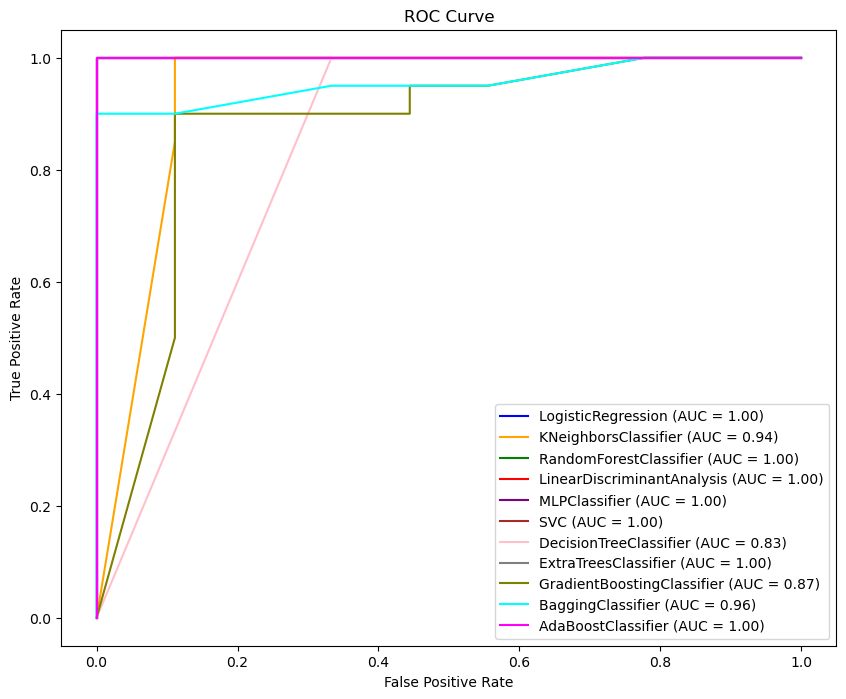

In [108]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

# 创建模型列表
models = [
    LogisticRegression(random_state=SEED),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=SEED),
    LinearDiscriminantAnalysis(),
    MLPClassifier(random_state=SEED),
    SVC(random_state=SEED, probability=True),  # 设置probability为True
    DecisionTreeClassifier(random_state=SEED),
    ExtraTreesClassifier(random_state=SEED),
    GradientBoostingClassifier(random_state=SEED),
    BaggingClassifier(random_state=SEED),
    AdaBoostClassifier(random_state=SEED)
]

# 创建颜色列表
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta']

# 绘制AUC曲线
plt.figure(figsize=(10, 8))
for model, color in zip(models, colors):
    # 训练模型
    model.fit(X_train, Y_train)
    
    # 获取模型在测试集上的预测概率值
    y_scores = model.predict_proba(X_test)[:, 1]
    
    # 计算FPR和TPR
    fpr, tpr, _ = roc_curve(Y_test, y_scores)
    
    # 计算AUC
    roc_auc = auc(fpr, tpr)
    
    # 绘制ROC曲线
    plt.plot(fpr, tpr, color=color, label=f'{type(model).__name__} (AUC = {roc_auc:.2f})')

# 设置图例和标签
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# 显示图形
plt.show()


# 保存模型

In [38]:
import pickle

# Save the models
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(dt_model, file)

with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

with open('lightgbm_model.pkl', 'wb') as file:
    pickle.dump(lgb_model, file)


# 验证集1数据处理

In [156]:
os.chdir("/share/home/linmiao/bio/2022_heartEC_scRNA/mRNA/230508_3Data/validation1")
print(os.getcwd())

/share/home/linmiao/bio/2022_heartEC_scRNA/mRNA/230508_3Data/validation1


In [157]:
# Load the external validation set 1
V1 = pd.read_csv('validation1_new.csv', index_col=0)  # Assuming the external validation set is in a CSV file named 'validation1.csv'

# Extract features and target variables
X_V1 = V1.drop('group', axis=1)
Y_V1 = V1['group']
X_V1.head()

VEGFA        FN1        EGF        KDR       FGF2      ITGB1  \
C00055  15.641355  16.656666  12.367969  13.372909  11.812023  17.147791   
C00192  14.980942  16.203126  11.624302  12.176503  11.573587  15.788818   
P01067  15.466566  19.686434  10.208246  13.970747  11.993540  17.916009   
P01101  15.139308  16.058564  11.792861  13.446936  12.027554  16.015498   
P01121  15.630496  16.582281  12.029900  15.044062  12.396994  16.799564   

           NOTCH1      HIF1A        TEK     PDGFRB  ...     TMEM2       SHH  \
C00055  11.638597  14.484383  14.009661  14.197021  ...  4.489448  4.161553   
C00192  11.020529  14.112662  12.459507  13.603597  ...  4.713090  4.255892   
P01067  11.613341  15.415126  13.603831  15.121639  ...  4.513779  4.324924   
P01101  11.734031  13.943612  12.982374  14.456784  ...  5.540496  4.032042   
P01121  11.442386  14.386747  13.717604  14.845968  ...  5.283996  4.474048   

           OVOL2   ANGPTL3      WARS     CD160    CXCL17     GPR56      FGF6  \
C00055  4.006460  4.034467  6.412688  4.418735  4.006524  5.023235  3.959387   
C00192  4.177102  4.150883  6.563060  4.467905  4.287059  5.908476  4.060307   
P01067  4.105320  4.205182  6.480667  4.437044  4.150746  5.600744  4.051116   
P01101  4.048450  4.076941  8.378456  4.435804  4.295747  5.925516  4.048242   
P01121  4.321322  4.171894  7.071871  4.827288  4.073277  6.214904  4.153738   

            FIGF  
C00055  3.989798  
C00192  4.084880  
P01067  4.214966  
P01101  4.114485  
P01121  4.270433  

[5 rows x 175 columns]

In [158]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np


# 创建空的结果表格
results_table = pd.DataFrame(columns=['Model', 'Accuracy_mean', 'Accuracy_std', 'Precision_mean', 'Precision_std',
                                      'Recall_mean', 'Recall_std', 'F1_Score_mean', 'F1_Score_std', 'AUC-ROC_mean', 'AUC-ROC_std'])

# 遍历之前生成的模型列表
for model in models:
    # 在外部验证集2上进行预测
    Y_V1_pred = model.predict(X_V1)
    
    # 计算评估指标的多次计算结果
    accuracy_scores = np.array([accuracy_score(Y_V1, Y_V1_pred)])
    precision_scores = np.array([precision_score(Y_V1, Y_V1_pred)])
    recall_scores = np.array([recall_score(Y_V1, Y_V1_pred)])
    f1_scores = np.array([f1_score(Y_V1, Y_V1_pred)])
    auc_roc_scores = np.array([roc_auc_score(Y_V1, Y_V1_pred)])
    
    # 计算评估指标的均值和标准差
    accuracy_mean = accuracy_scores.mean()
    accuracy_std = accuracy_scores.std()
    precision_mean = precision_scores.mean()
    precision_std = precision_scores.std()
    recall_mean = recall_scores.mean()
    recall_std = recall_scores.std()
    f1_mean = f1_scores.mean()
    f1_std = f1_scores.std()
    auc_roc_mean = auc_roc_scores.mean()
    auc_roc_std = auc_roc_scores.std()
    
    # 将结果添加到结果表格
    results_table = results_table.append({
        'Model': type(model).__name__,
        'Accuracy_mean': accuracy_mean,
        'Accuracy_std': accuracy_std,
        'Precision_mean': precision_mean,
        'Precision_std': precision_std,
        'Recall_mean': recall_mean,
        'Recall_std': recall_std,
        'F1_Score_mean': f1_mean,
        'F1_Score_std': f1_std,
        'AUC-ROC_mean': auc_roc_mean,
        'AUC-ROC_std': auc_roc_std
    }, ignore_index=True)

# 将结果表格导出为CSV文件
results_table.to_csv('ex_validation1_results.csv', index=False)


# 外部验证集2 数据处理

In [151]:
os.chdir("/share/home/linmiao/bio/2022_heartEC_scRNA/mRNA/230508_3Data/validation2")
print(os.getcwd())

/share/home/linmiao/bio/2022_heartEC_scRNA/mRNA/230508_3Data/validation2


In [154]:
# Load the external validation set 1
V2 = pd.read_csv('validation2.csv', index_col=0)  # Assuming the external validation set is in a CSV file named 'validation1.csv'

# Extract features and target variables
X_V2 = np.log1p(V2.drop('group', axis=1))
Y_V2 = V2['group']
X_V2.head()

VEGFA        FN1       EGF       KDR      FGF2      ITGB1  \
GSM4887610  6.703188   8.395703  5.855072  6.848005  4.709530   9.024974   
GSM4887611  6.745236   9.062072  5.609472  7.229839  4.882802   9.260843   
GSM4887612  6.877296  11.641486  4.882802  6.624065  4.615121  10.214129   
GSM4887613  6.469250   8.203030  5.777652  6.900731  4.317488   8.905716   
GSM4887614  6.969791  10.688918  5.342334  6.777647  5.262690   9.343559   

              NOTCH1     HIF1A       TEK    PDGFRB  ...     TDGF1     OVOL2  \
GSM4887610  5.805135  6.942157  6.263398  7.425358  ...  1.592337  1.610729   
GSM4887611  5.902633  6.970730  6.754604  7.091742  ...  1.622873  1.644245   
GSM4887612  5.916202  7.365813  6.523562  7.498316  ...  1.629349  1.630283   
GSM4887613  5.231109  6.513230  6.113682  6.879356  ...  1.617604  1.619081   
GSM4887614  6.204558  8.130942  6.565265  7.636752  ...  1.651371  1.671722   

                WARS      EREG     PDCD6       LEP   TNFSF12     GPR56  \
GSM4887610  2.003193  1.631173  1.977233  1.741643  1.758549  1.795624   
GSM4887611  2.023276  1.651440  2.063217  1.879239  1.801048  1.932749   
GSM4887612  2.012322  1.644521  2.062140  1.788751  1.848307  1.887182   
GSM4887613  2.238415  1.660796  2.083716  1.771053  1.809746  1.935213   
GSM4887614  2.088385  1.698588  2.080524  1.802487  1.808929  1.976149   

                FGF6      FIGF  
GSM4887610  1.601282  1.607395  
GSM4887611  1.621427  1.626271  
GSM4887612  1.619609  1.651533  
GSM4887613  1.619040  1.632077  
GSM4887614  1.639722  1.662112  

[5 rows x 175 columns]

In [155]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np


# 创建空的结果表格
results_table = pd.DataFrame(columns=['Model', 'Accuracy_mean', 'Accuracy_std', 'Precision_mean', 'Precision_std',
                                      'Recall_mean', 'Recall_std', 'F1_Score_mean', 'F1_Score_std', 'AUC-ROC_mean', 'AUC-ROC_std'])

# 遍历之前生成的模型列表
for model in models:
    # 在外部验证集2上进行预测
    Y_V2_pred = model.predict(X_V2)
    
    # 计算评估指标的多次计算结果
    accuracy_scores = np.array([accuracy_score(Y_V2, Y_V2_pred)])
    precision_scores = np.array([precision_score(Y_V2, Y_V2_pred)])
    recall_scores = np.array([recall_score(Y_V2, Y_V2_pred)])
    f1_scores = np.array([f1_score(Y_V2, Y_V2_pred)])
    auc_roc_scores = np.array([roc_auc_score(Y_V2, Y_V2_pred)])
    
    # 计算评估指标的均值和标准差
    accuracy_mean = accuracy_scores.mean()
    accuracy_std = accuracy_scores.std()
    precision_mean = precision_scores.mean()
    precision_std = precision_scores.std()
    recall_mean = recall_scores.mean()
    recall_std = recall_scores.std()
    f1_mean = f1_scores.mean()
    f1_std = f1_scores.std()
    auc_roc_mean = auc_roc_scores.mean()
    auc_roc_std = auc_roc_scores.std()
    
    # 将结果添加到结果表格
    results_table = results_table.append({
        'Model': type(model).__name__,
        'Accuracy_mean': accuracy_mean,
        'Accuracy_std': accuracy_std,
        'Precision_mean': precision_mean,
        'Precision_std': precision_std,
        'Recall_mean': recall_mean,
        'Recall_std': recall_std,
        'F1_Score_mean': f1_mean,
        'F1_Score_std': f1_std,
        'AUC-ROC_mean': auc_roc_mean,
        'AUC-ROC_std': auc_roc_std
    }, ignore_index=True)

# 将结果表格导出为CSV文件
results_table.to_csv('ex_validation2_results_log.csv', index=False)
